In [2]:
!python -m pip install --user --upgrade pip
!pip install --user keras
!pip install --user numpy
!pip install --user tensorflow

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Created wheel for absl-py: filename=absl_py-0.7.1-cp36-none-any.whl size=113722 sha256=bcb3d3a2f927f141b824ed51a8bf767f3299918a2d0da9364507b2dda41fa279
  Stored in directory: C:\Users\wangmi94\AppData\Local\pip\Cache\wheels\ee\98\38\46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=6594 sha256=bfb5212c485ca4c328ebf2fdcb78c4f8d6a3e7370477cab98fbb0d9911d35222
  Stored in directory: C:\Users\wangmi94\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Created wheel for termcolor: filename=termcolor-1.1.0-cp36-none-any.whl size=4006 sha256=ac9fb2f68d81fa951299cd49bda2f57f08c5aba759510b4c6bd24804668cfcb1
  Stored in directory: C:\Users\wangmi94\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Created wheel for wrapt: filename=wrapt-1.11.2-cp36-none-any.whl size=18733 sha256=469482c4534411af0cc57ceee95ba5d881ebed728c70b977a858487e2750fc3

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
import pandas as pd
import numpy as np
from keras.models import load_model, Sequential
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras import backend as K
import sklearn.metrics as skm, math
#from sklearn.utils.validation import check_array

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\wangmi94\AppData\R

In [2]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))
def mpe(y_true, y_pred):
    errors = K.sqrt(K.mean((y_true-y_pred)**2))/K.mean(y_true)
    return errors

def exp(x):
    return K.exp(x)

### With Implied Volatility

In [3]:
#Load saved model
model = load_model('model4_1_2.h5')
model.summary()

W0824 23:05:12.628305 14816 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0824 23:05:12.644318 14816 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0824 23:05:12.732352 14816 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0824 23:05:12.732352 14816 deprecation_wrapper.py:119] From C:\Users\wangmi94\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:200: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.Confi

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 50)                400       
_________________________________________________________________
dense_8 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_9 (Dense)              (None, 300)               30300     
_________________________________________________________________
dense_10 (Dense)             (None, 500)               150500    
_________________________________________________________________
dense_11 (Dense)             (None, 100)               50100     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 236,501
Trainable params: 236,501
Non-trainable params: 0
________________________________________________

In [4]:
def intrinsic(S, K, C, P):
    return C*(max(S-K, 0)) + P*(max(K-S, 0))

In [5]:
def load_data():
    df = pd.read_csv('Options_R_test.csv')
    df = df.dropna()
    
    # Calculate the intrinsic value of all the options
    df['intrinsic'] = df.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], row['cp_flag_P']), axis = 1)
    
    df[['strike_price', 'underlying_price', 'maturity', 'impl_volatility', 'realized_vol', 'cp_flag_C', 'cp_flag_P', 
                    'interest_rate', 'intrinsic', 'best_offer']].apply(pd.to_numeric)
    #sample_df = sample_df.reset_index(drop=True)
    
    return df

In [6]:
df = load_data()
df.head()

,ticker,date,exdate,maturity,strike_price,best_offer,impl_volatility,realized_vol,underlying_price,interest_rate,cp_flag_C,cp_flag_P,intrinsic
0,AXP,2016-01-04,2016-01-08,4,100.0,0.13,1.695791,0.208476,67.59,0.0022,1,0,0.00
1,AXP,2016-01-04,2016-01-08,4,105.0,0.13,1.869624,0.208476,67.59,0.0022,1,0,0.00
2,AXP,2016-01-04,2016-01-08,4,66.0,1.70,0.238987,0.208476,67.59,0.0022,1,0,1.59
3,AXP,2016-01-04,2016-01-08,4,66.5,1.31,0.246213,0.208476,67.59,0.0022,1,0,1.09
4,AXP,2016-01-04,2016-01-08,4,67.0,0.95,0.242758,0.208476,67.59,0.0022,1,0,0.59


In [7]:
def mean_sum_error(y_true, y_pred):
    errors = np.sum(np.abs(y_true-y_pred))/np.sum(y_true)
    return errors

In [8]:
def model_pred(df, model, vol):
    
    y = df['best_offer'].values
    X = df[[ 'intrinsic', 'strike_price', 'underlying_price', 'maturity', vol, 'cp_flag_P', 'interest_rate',]]
    
#     sc_X = StandardScaler()
#     X_scale = sc_X.fit_transform(X)

#     sc_y = StandardScaler()
#     y = y.reshape(-1,1)
#     y_scale = sc_y.fit_transform(y)
    
    pred = model.predict(X)
    #print('y_scale data:\n', y_scale[:10])
    print('y_predition:\n', pred[:10])
    print('\n')
    
    #y_pred = sc_y.inverse_transform(pred)
    print('actual value:\n', y[:10])
    #print('actual predicted value:\n', y_pred[:10])
    print('\n')
    
    pred = pred.flatten()
    
    d = {'predict': pred, 'actual':y}
    
    datanew = pd.DataFrame(data = d)
    
    sample_data = datanew.sample(n=150)
    
    sample_data.sort_index(axis = 0, inplace = True)
    
    #display(sample_data)
    
    plt.figure(1,figsize = (20,15))
    plt.plot(sample_data.index, sample_data['predict'], linestyle = '-', label = 'predicted')
    plt.plot(sample_data.index, sample_data['actual'], linestyle = '-', label = 'actual')
    plt.ylabel('price', fontsize = 20)
    plt.legend(prop={'size': 20})
    plt.title('Predicted vs Actual Values', fontsize = 30)
    plt.figure(2,figsize = (20,15))
    plt.show()
    
    
    
    #print("Average sum error:              %f" % mean_sum_error(y, pred))
    print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y, pred))
    print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y, pred))
    print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y, pred)))
    print("R square (R^2):                 %f" % skm.r2_score(y, pred)) 

In [11]:
def model_pred_diff(df, model, vol):
    
    y = df['best_offer'].values
    X = df[[ 'intrinsic', 'strike_price', 'underlying_price', 'maturity', vol, 'cp_flag_P', 'interest_rate',]]
    
#     sc_X = StandardScaler()
#     X_scale = sc_X.fit_transform(X)

#     sc_y = StandardScaler()
#     y = y.reshape(-1,1)
#     y_scale = sc_y.fit_transform(y)
    
    pred = model.predict(X)
    #print('y_scale data:\n', y_scale[:10])
    print('y_predition:\n', pred[:10])
    print('\n')
    
    #y_pred = sc_y.inverse_transform(pred)
    print('actual value:\n', y[:10])
    #print('actual predicted value:\n', y_pred[:10])
    print('\n')
    
    pred = pred.flatten()
    
    d = {'predict': pred, 'actual':y}
    
    datanew = pd.DataFrame(data = d)
    
    sample_data = datanew.sample(n=150)
    
    sample_data.sort_index(axis = 0, inplace = True)

    datanew.sort_index(axis = 0, inplace = True)
    
    #display(sample_data)
    
    #Diff plot for all data
    plt.figure(1,figsize = (20,15))
    plt.plot(datanew.index, datanew['predict']-datanew['actual'], linestyle = '-', label = 'difference')
    #plt.plot(sample_data.index, sample_data['predict']-sample_data['actual'], linestyle = '-', label = 'actual')
    plt.ylabel('price', fontsize = 20)
    plt.legend(prop={'size': 20})
    plt.title('Difference of prediction and actual ground truth for all data', fontsize = 30)
    #Line graph for all data
    plt.figure(2,figsize = (20,15))
    plt.plot(datanew.index, datanew['predict'], linestyle = '-', label = 'predicted')
    plt.plot(datanew.index, datanew['actual'], linestyle = '-', label = 'actual')
    plt.ylabel('price', fontsize = 20)
    plt.legend(prop={'size': 20})
    plt.title('Predicted vs Actual Values for all data', fontsize = 30)
    plt.show()
    #Diff plot for random 150 data
    plt.figure(3,figsize = (20,15))
    plt.plot(sample_data.index, sample_data['predict']-sample_data['actual'], linestyle = '-', label = 'difference')
    #plt.plot(sample_data.index, sample_data['predict']-sample_data['actual'], linestyle = '-', label = 'actual')
    plt.ylabel('price', fontsize = 20)
    plt.legend(prop={'size': 20})
    plt.title('Difference of prediction and actual ground truth for random 150 data points', fontsize = 30)
    #Line graph for random 150 data
    plt.figure(4,figsize = (20,15))
    plt.plot(sample_data.index, sample_data['predict'], linestyle = '-', label = 'predicted')
    plt.plot(sample_data.index, sample_data['actual'], linestyle = '-', label = 'actual')
    plt.ylabel('price', fontsize = 20)
    plt.legend(prop={'size': 20})
    plt.title('Predicted vs Actual Values for random 150 points', fontsize = 30)
    plt.show()
    
    
    #print("Average sum error:              %f" % mean_sum_error(y, pred))
    print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y, pred))
    print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y, pred))
    print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y, pred)))
    print("R square (R^2):                 %f" % skm.r2_score(y, pred)) 

y_predition:
 [[1.1790973 ]
 [1.4163775 ]
 [1.9721425 ]
 [1.5568271 ]
 [1.101272  ]
 [0.78924966]
 [0.6103319 ]
 [0.4279031 ]
 [0.30916193]
 [0.2369523 ]]


actual value:
 [0.13 0.13 1.7  1.31 0.95 0.66 0.44 0.28 0.17 0.1 ]




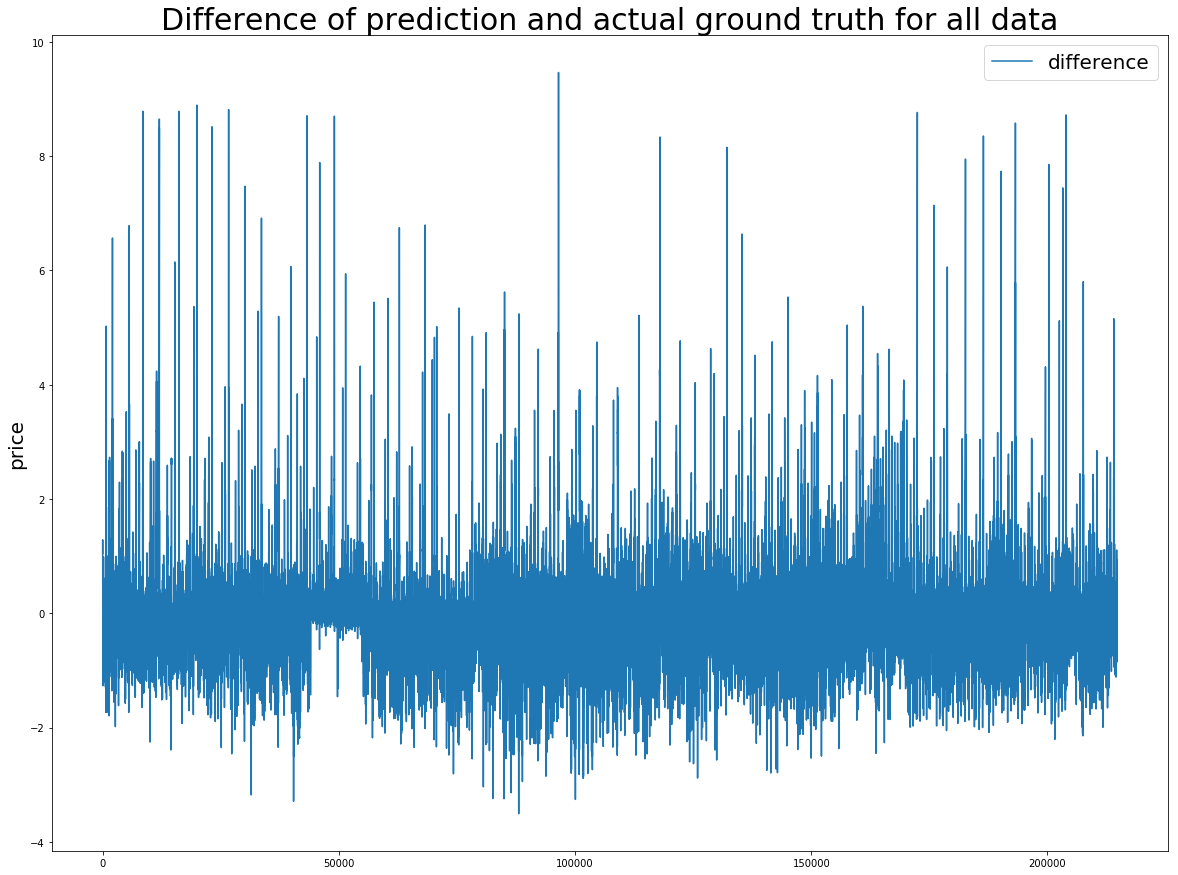

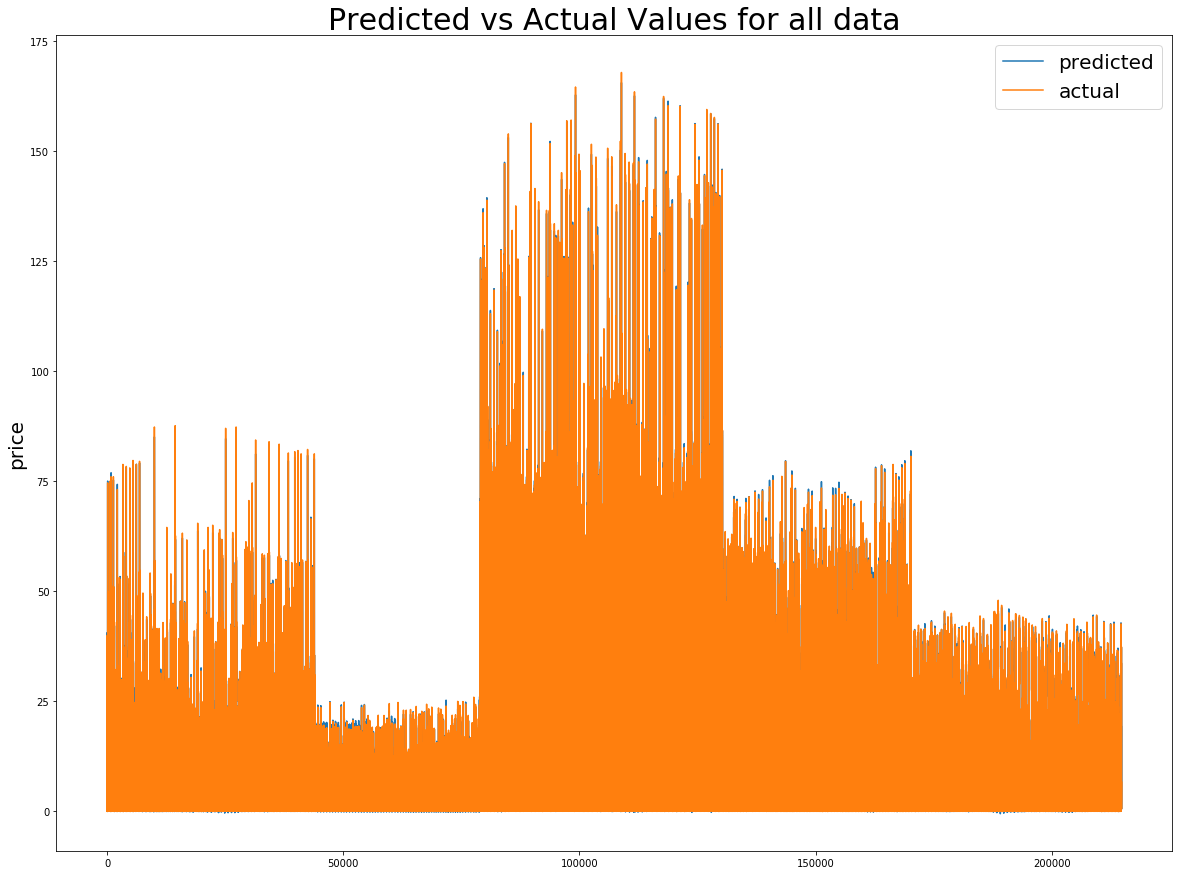

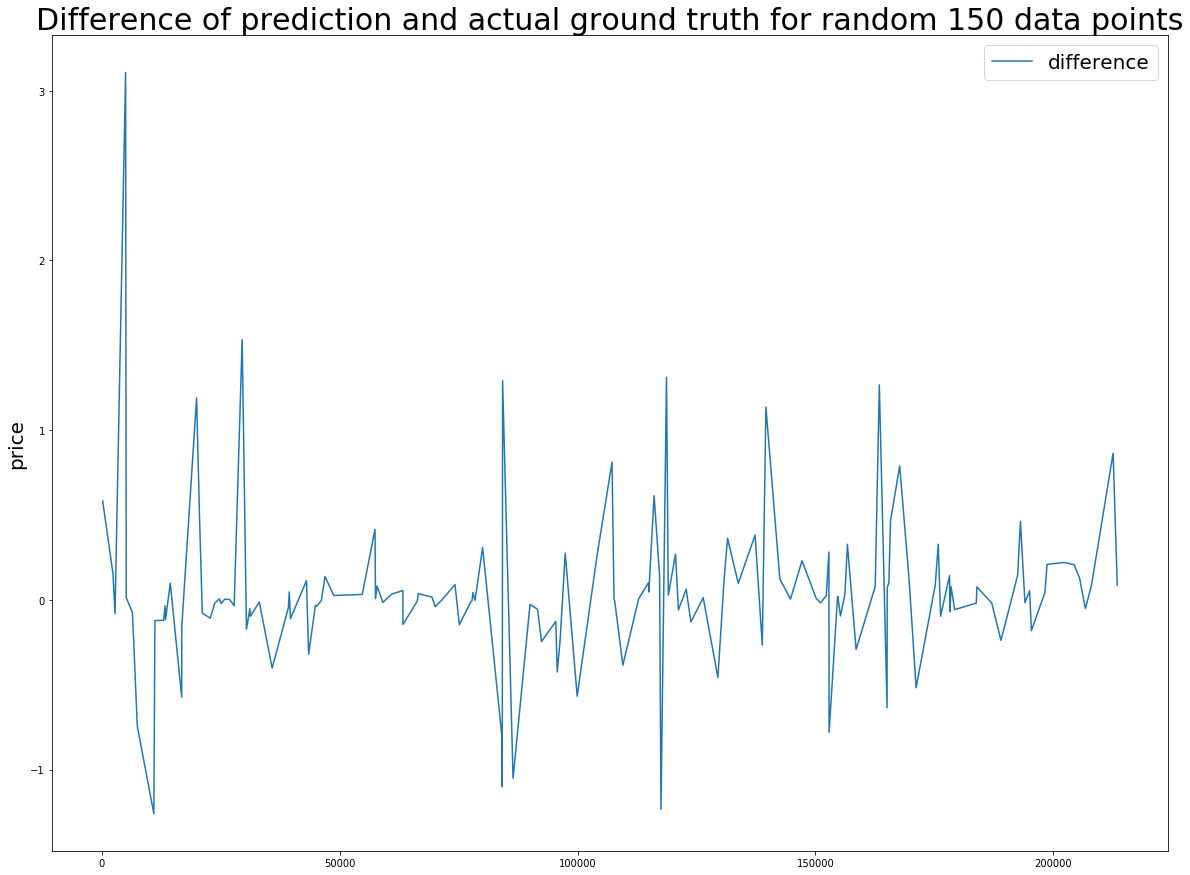

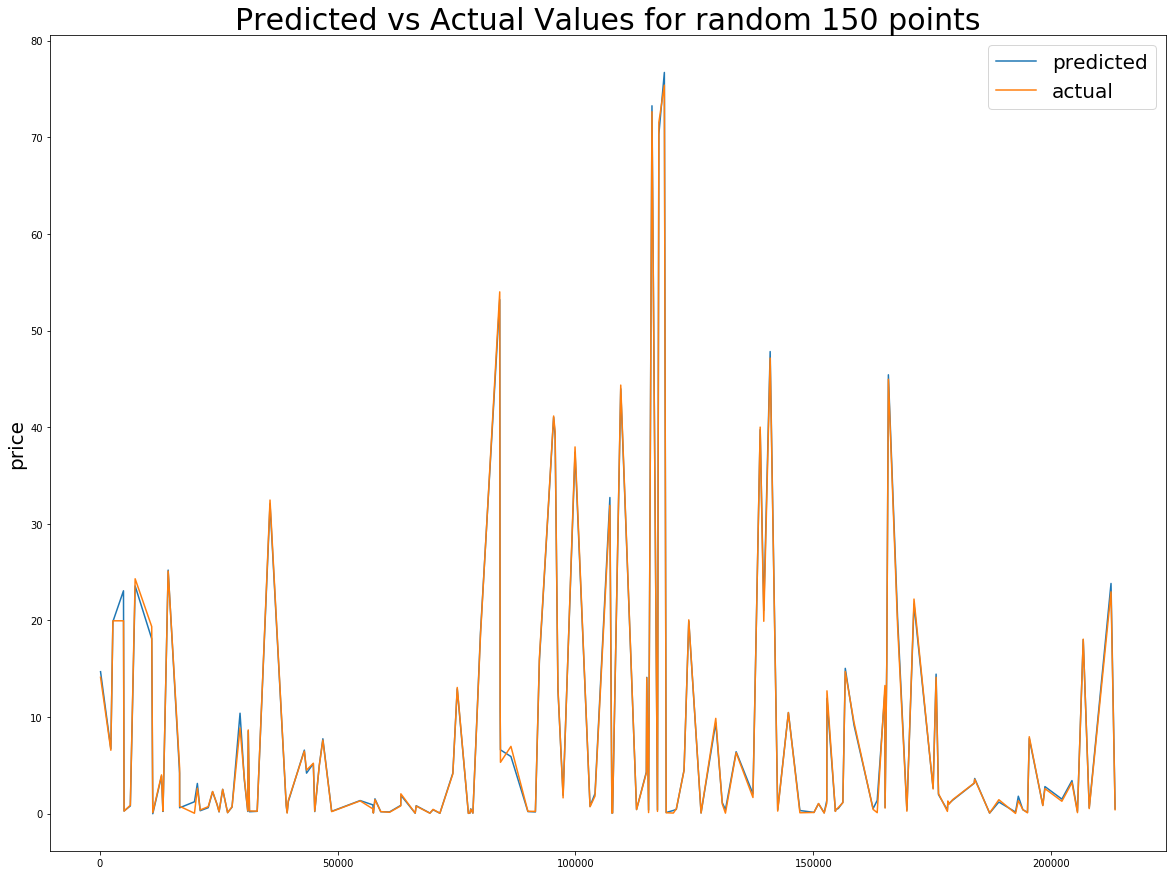

Mean absolute error (MAE):      0.292941
Mean squared error (MSE):       0.363107
Root mean squared error (RMSE): 0.602584
R square (R^2):                 0.998357


In [12]:
#model_pred(df, model, 'impl_volatility')
model_pred_diff(df, model, 'impl_volatility')

### With Realized Volatility

y_predition:
 [[0.6119089 ]
 [0.63889855]
 [1.9190342 ]
 [1.5176442 ]
 [1.0424713 ]
 [0.73795736]
 [0.5319629 ]
 [0.33777076]
 [0.21623759]
 [0.11498455]]


actual value:
 [0.13 0.13 1.7  1.31 0.95 0.66 0.44 0.28 0.17 0.1 ]




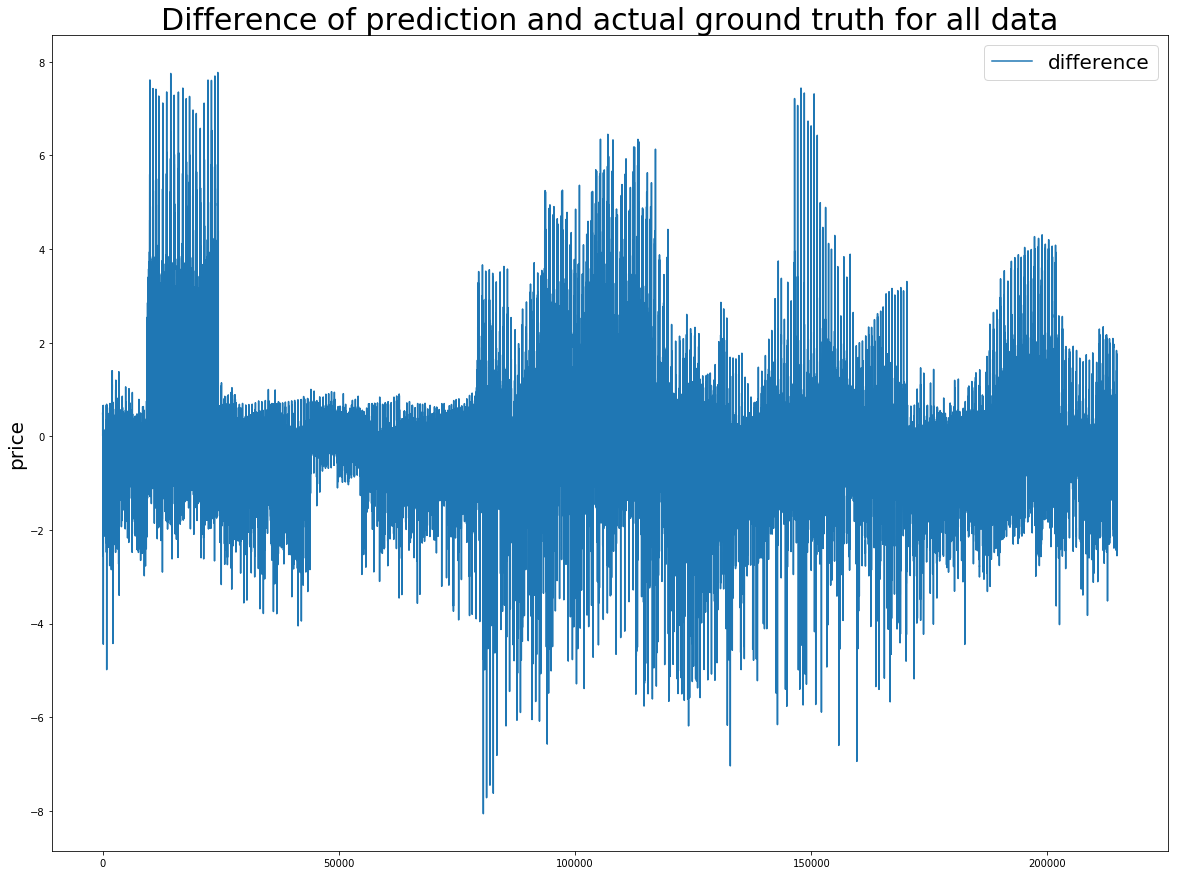

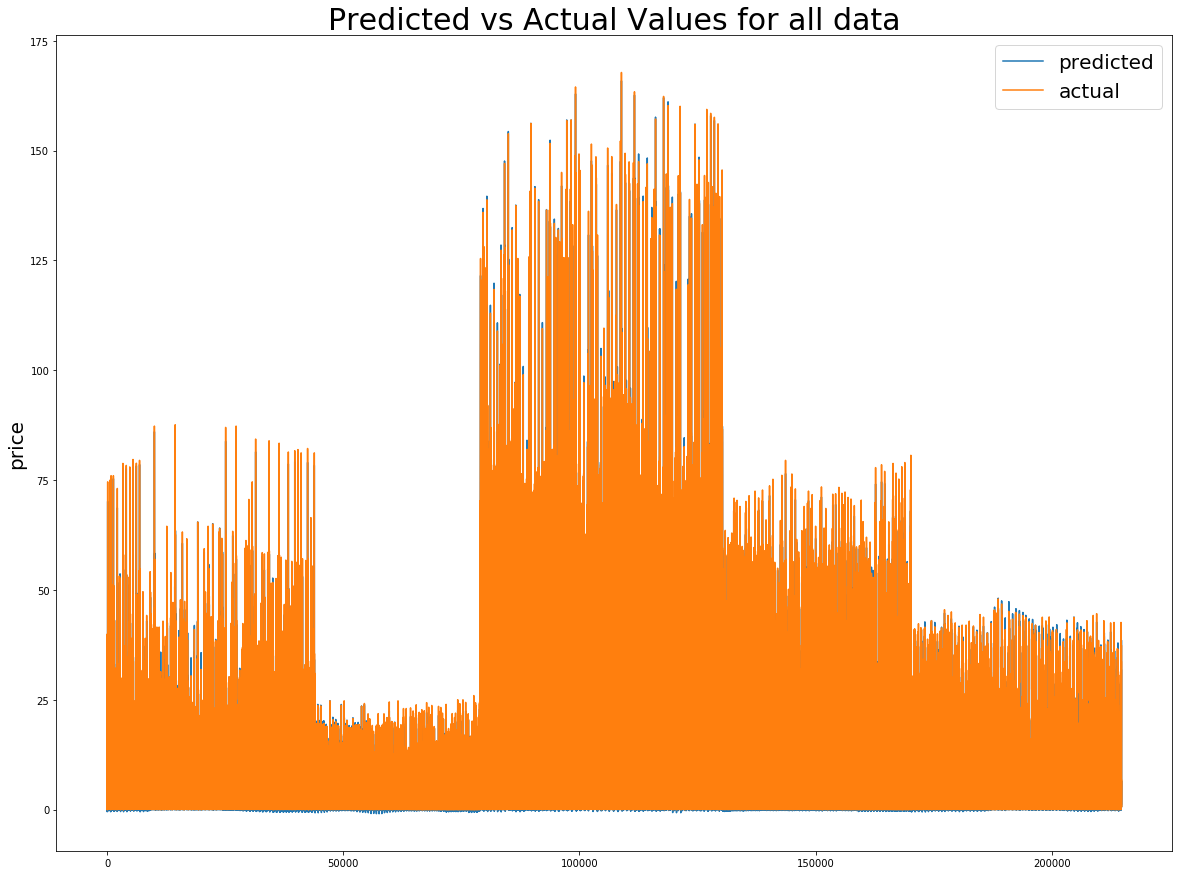

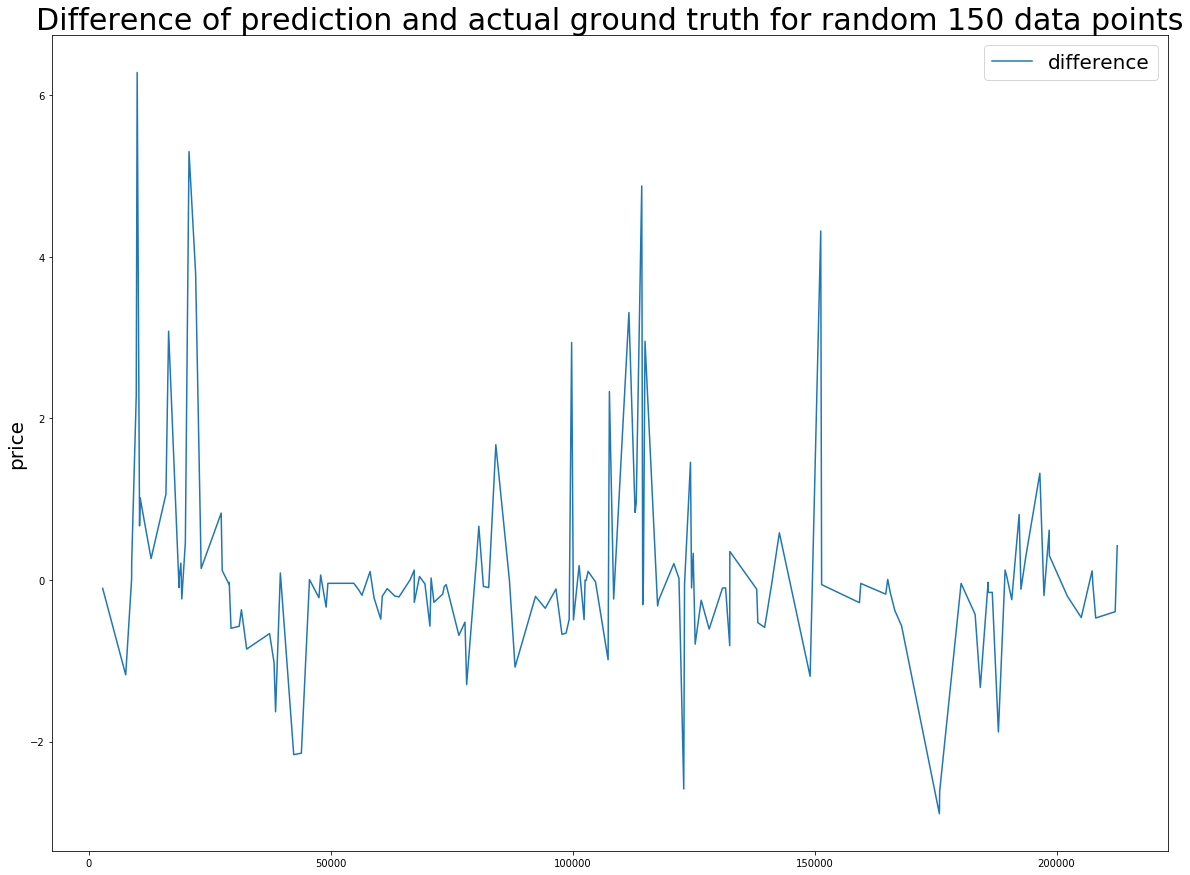

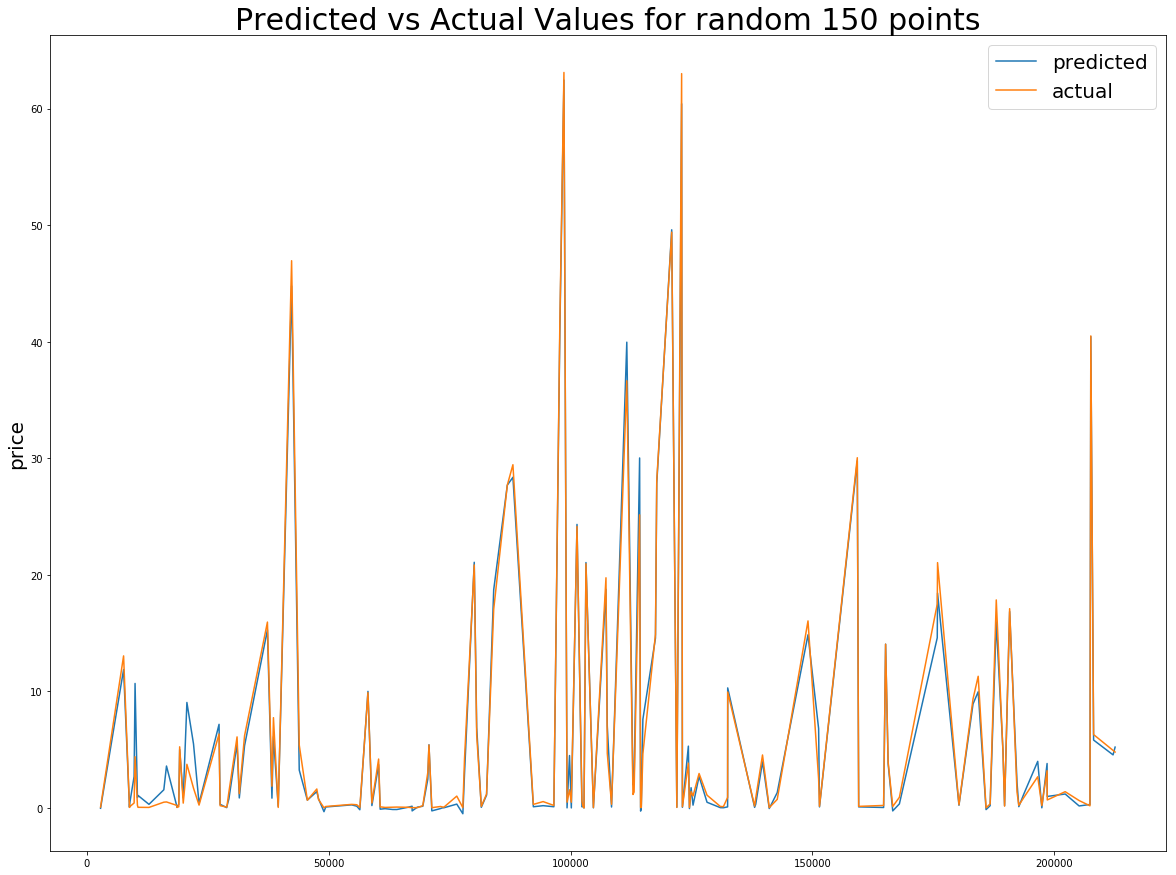

Mean absolute error (MAE):      0.647883
Mean squared error (MSE):       1.149325
Root mean squared error (RMSE): 1.072066
R square (R^2):                 0.994800


In [13]:
model_pred_diff(df, model, 'realized_vol')

#### Predict special ticker which was used to train the model

y_predition:
 [[2.7395248 ]
 [1.8224508 ]
 [0.9604683 ]
 [0.4982036 ]
 [0.27841458]
 [0.16883484]
 [0.04081071]
 [0.0241561 ]
 [0.01905416]
 [0.01399205]]


actual value:
 [3.1  2.23 1.49 0.9  0.49 0.25 0.13 0.07 0.05 0.13]




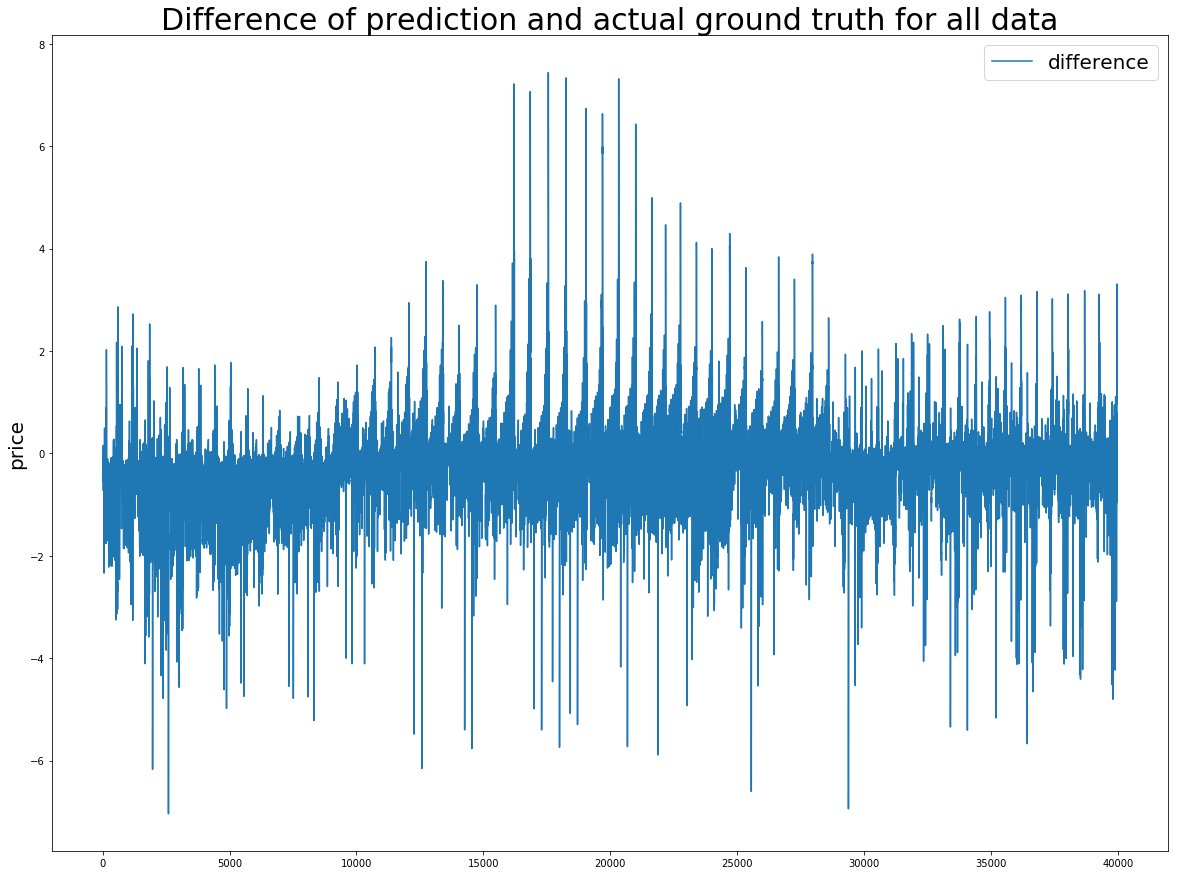

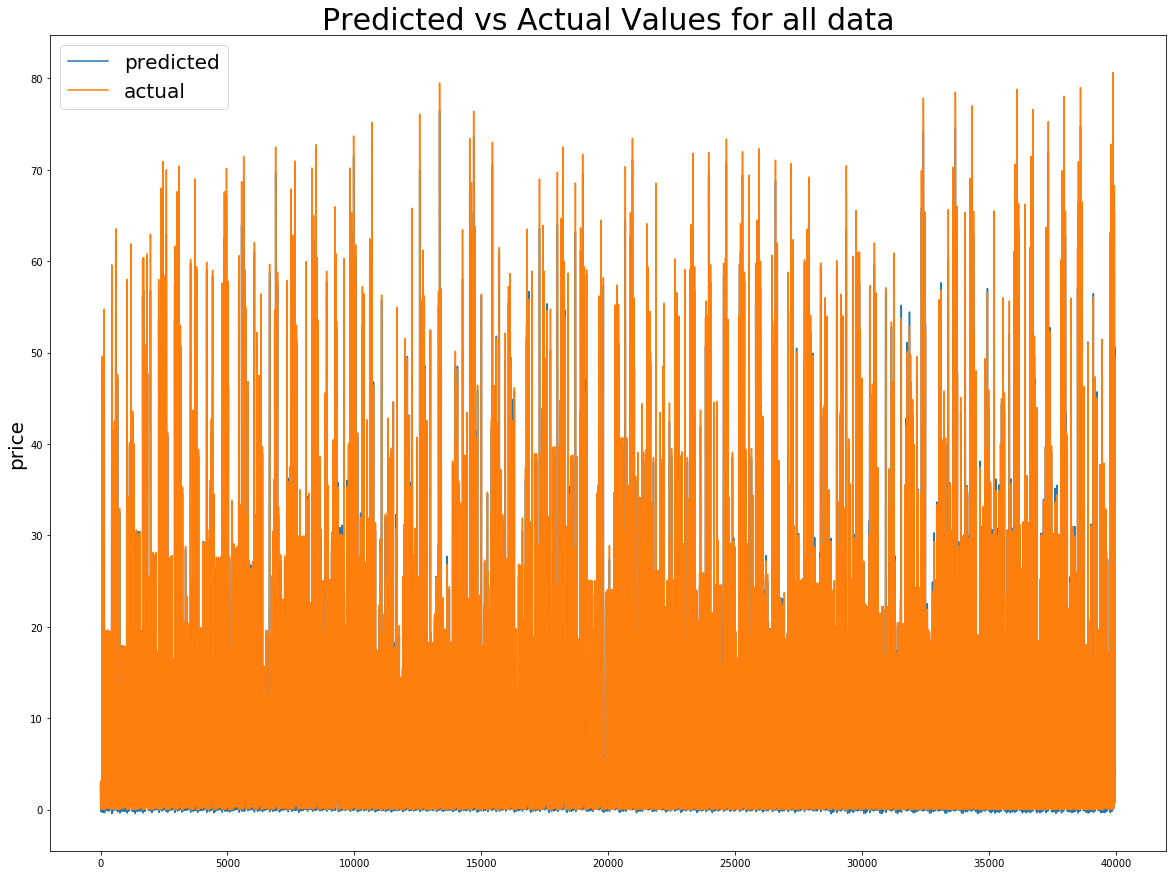

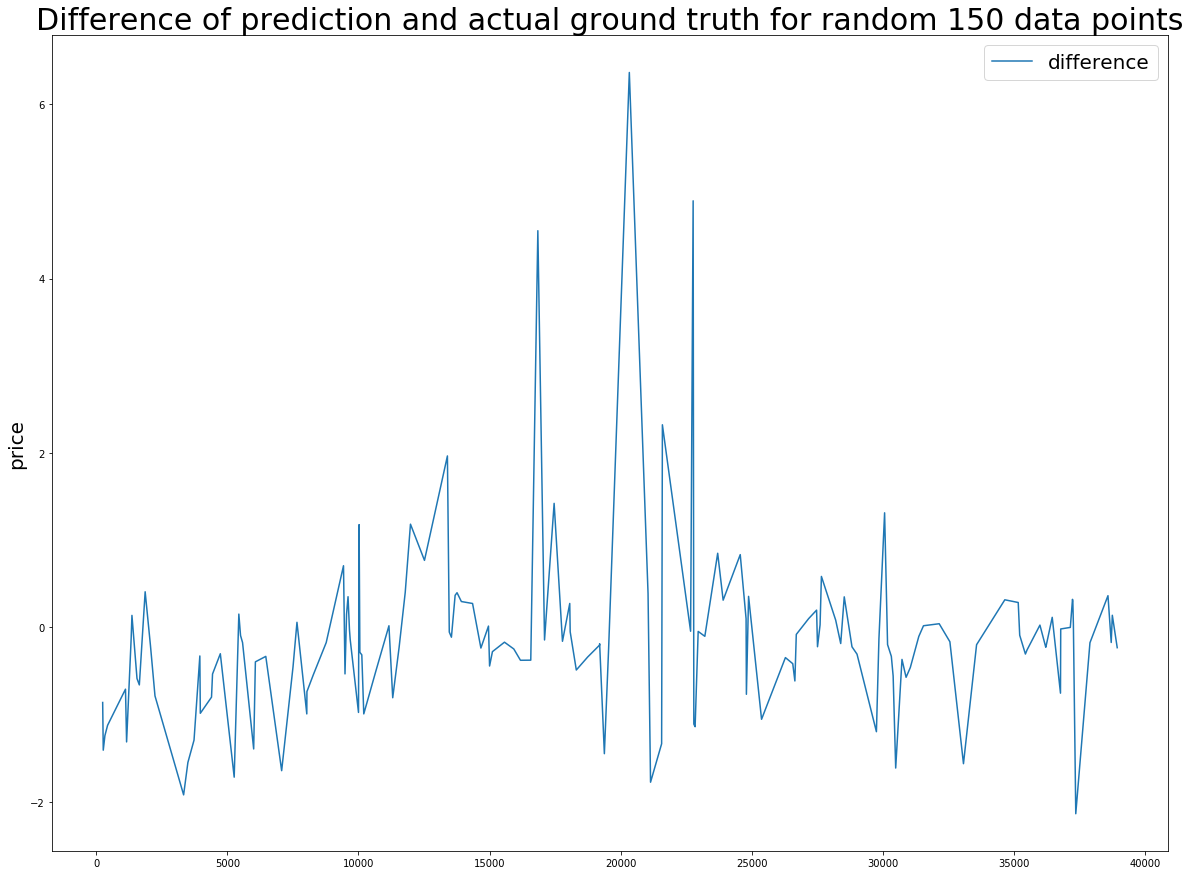

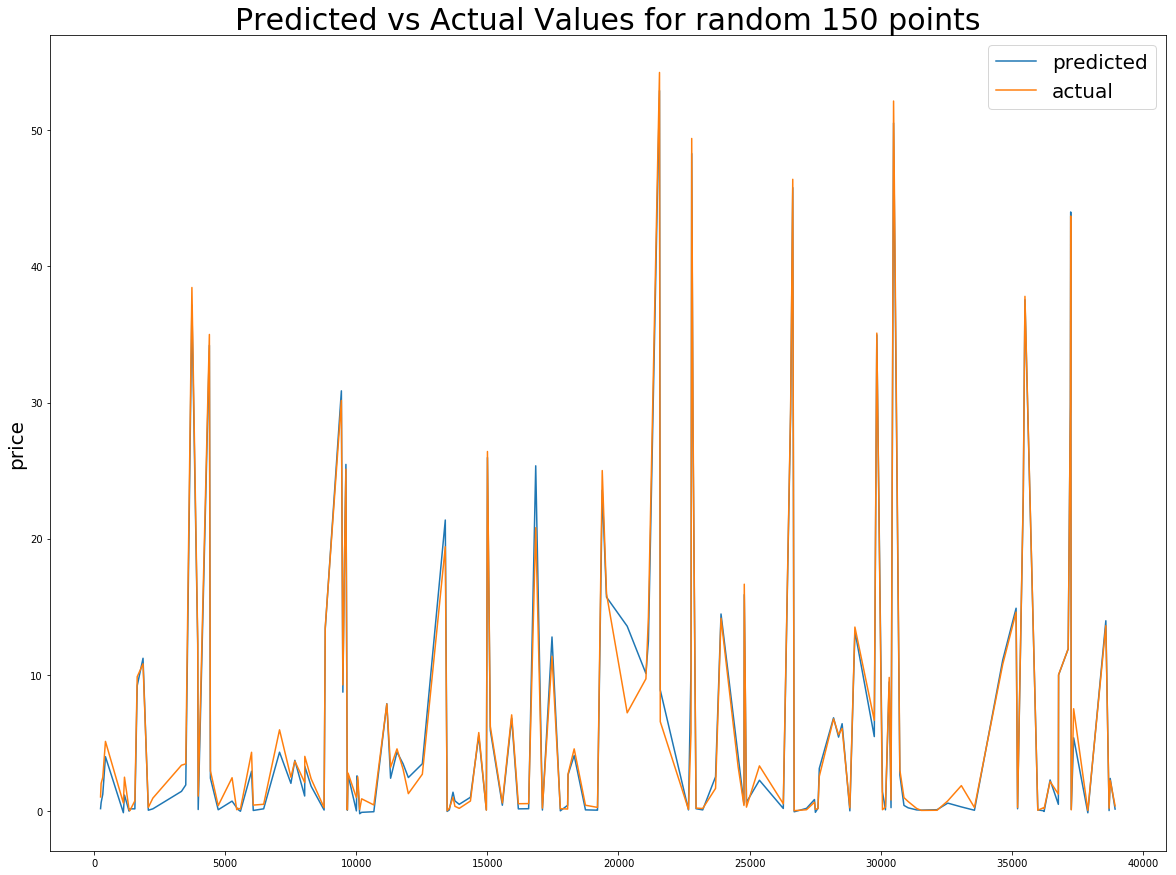

Mean absolute error (MAE):      0.591240
Mean squared error (MSE):       0.808429
Root mean squared error (RMSE): 0.899127
R square (R^2):                 0.994484


In [14]:
MCD = df[df.ticker == 'MCD']
model_pred_diff(MCD, model, 'realized_vol')

y_predition:
 [[3.2593567 ]
 [2.5053728 ]
 [1.5827233 ]
 [1.08799   ]
 [0.64094615]
 [0.3673861 ]
 [0.22306153]
 [0.16667484]
 [0.14499983]
 [0.22865224]]


actual value:
 [3.1  2.23 1.49 0.9  0.49 0.25 0.13 0.07 0.05 0.13]




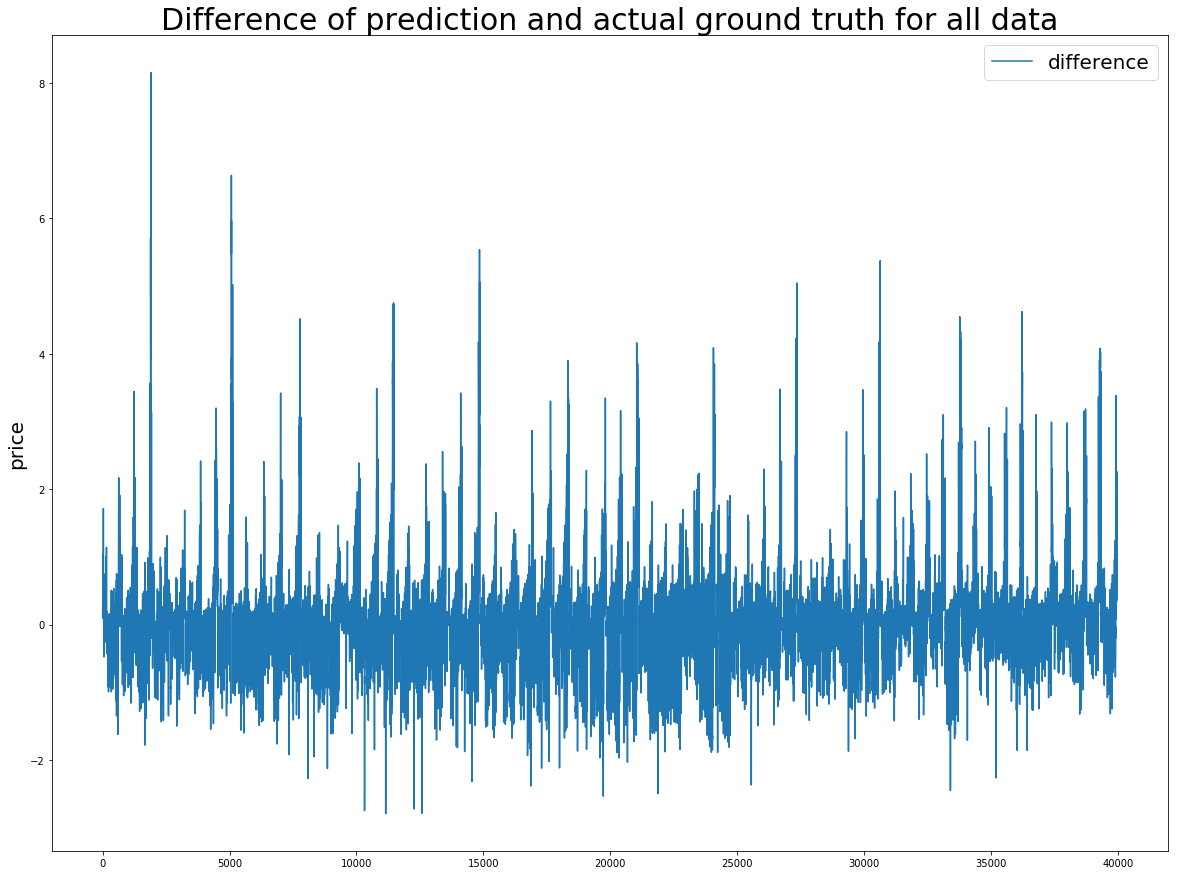

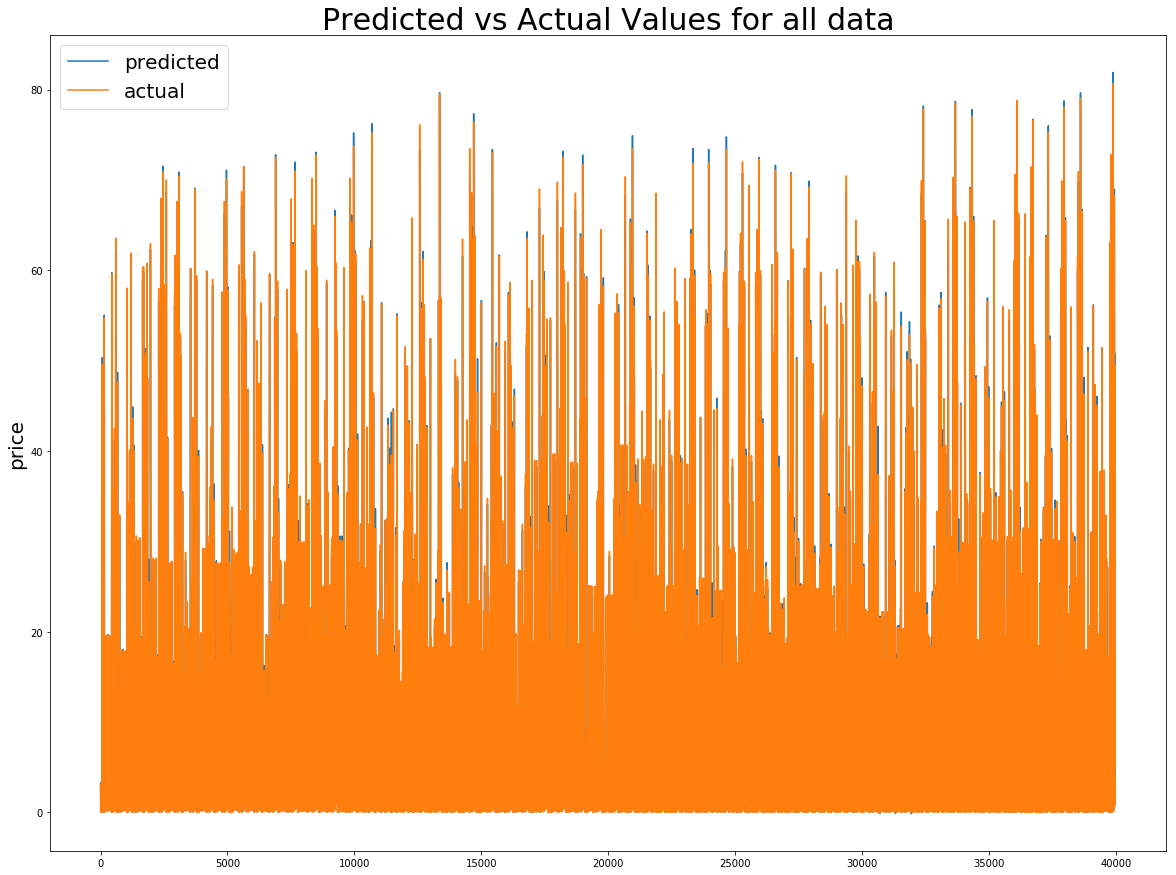

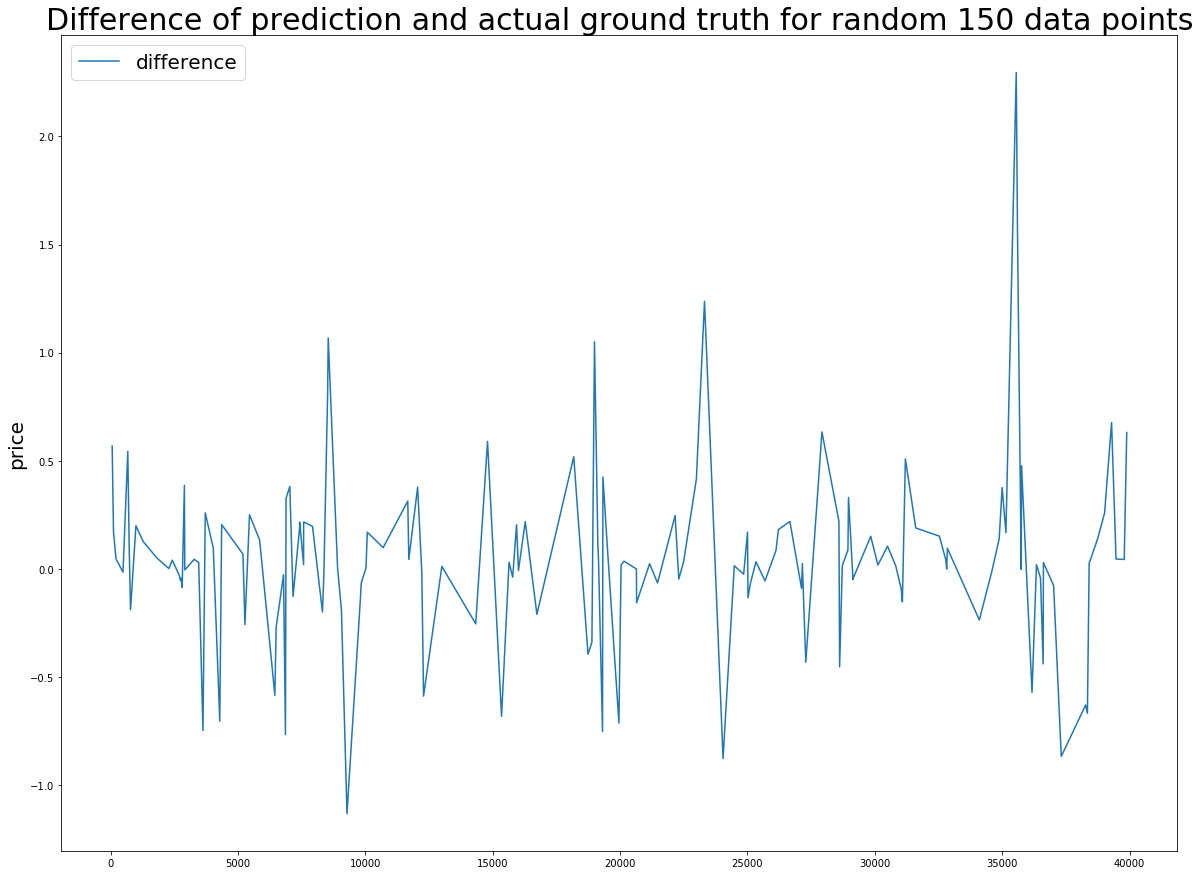

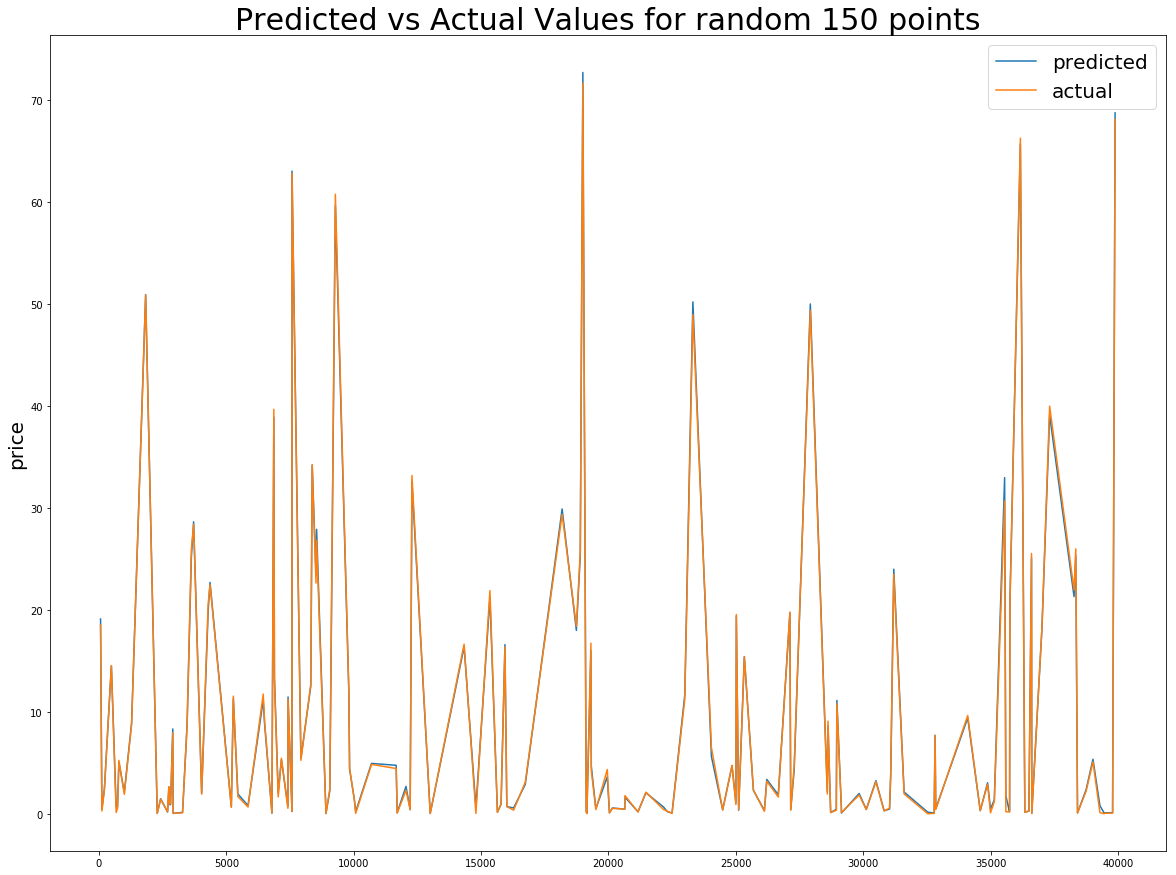

Mean absolute error (MAE):      0.338774
Mean squared error (MSE):       0.397772
Root mean squared error (RMSE): 0.630691
R square (R^2):                 0.997286


In [15]:
model_pred_diff(MCD, model, 'impl_volatility')

y_predition:
 [[5.9563656 ]
 [4.106683  ]
 [2.6282334 ]
 [1.7206304 ]
 [0.99700814]
 [0.5807913 ]
 [0.3055017 ]
 [0.15160613]
 [0.05920184]
 [0.05702769]]


actual value:
 [5.45 3.5  2.02 1.04 0.47 0.21 0.12 0.07 0.13 0.03]




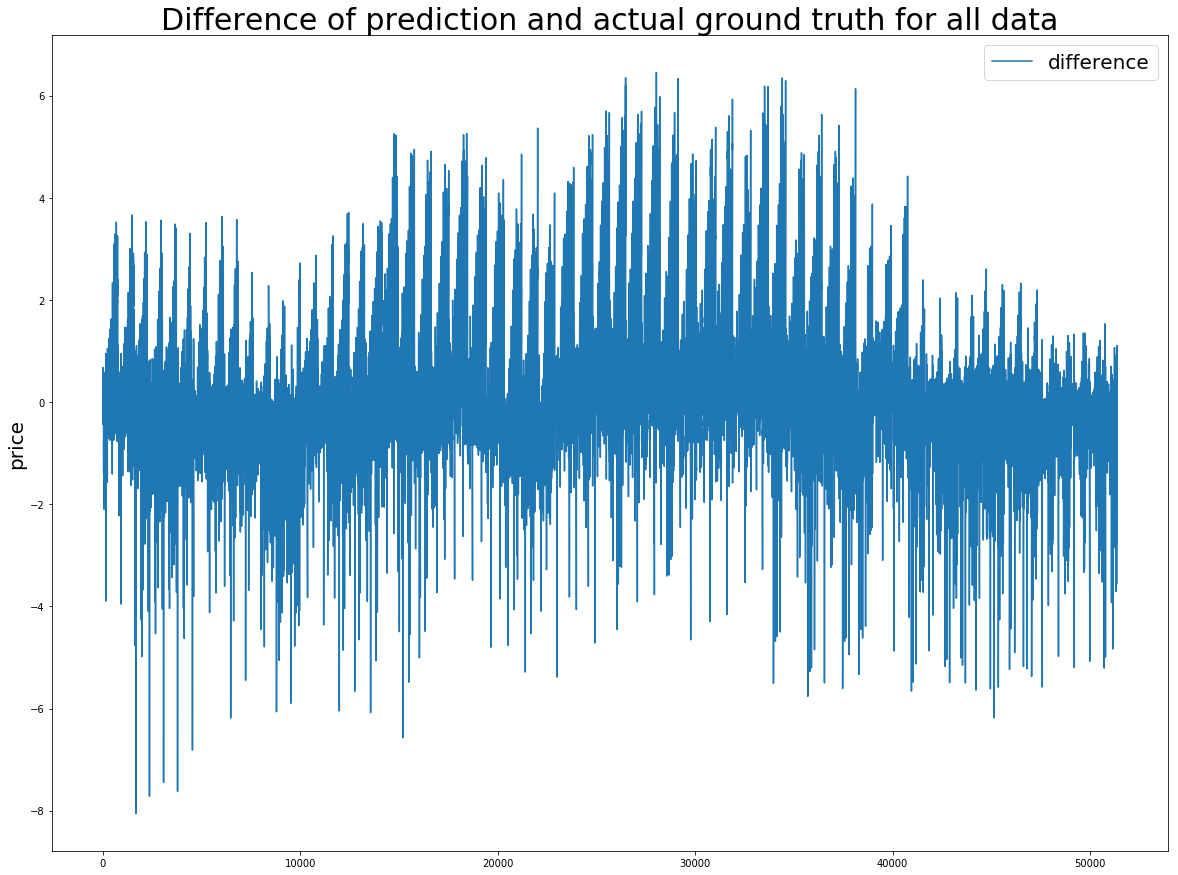

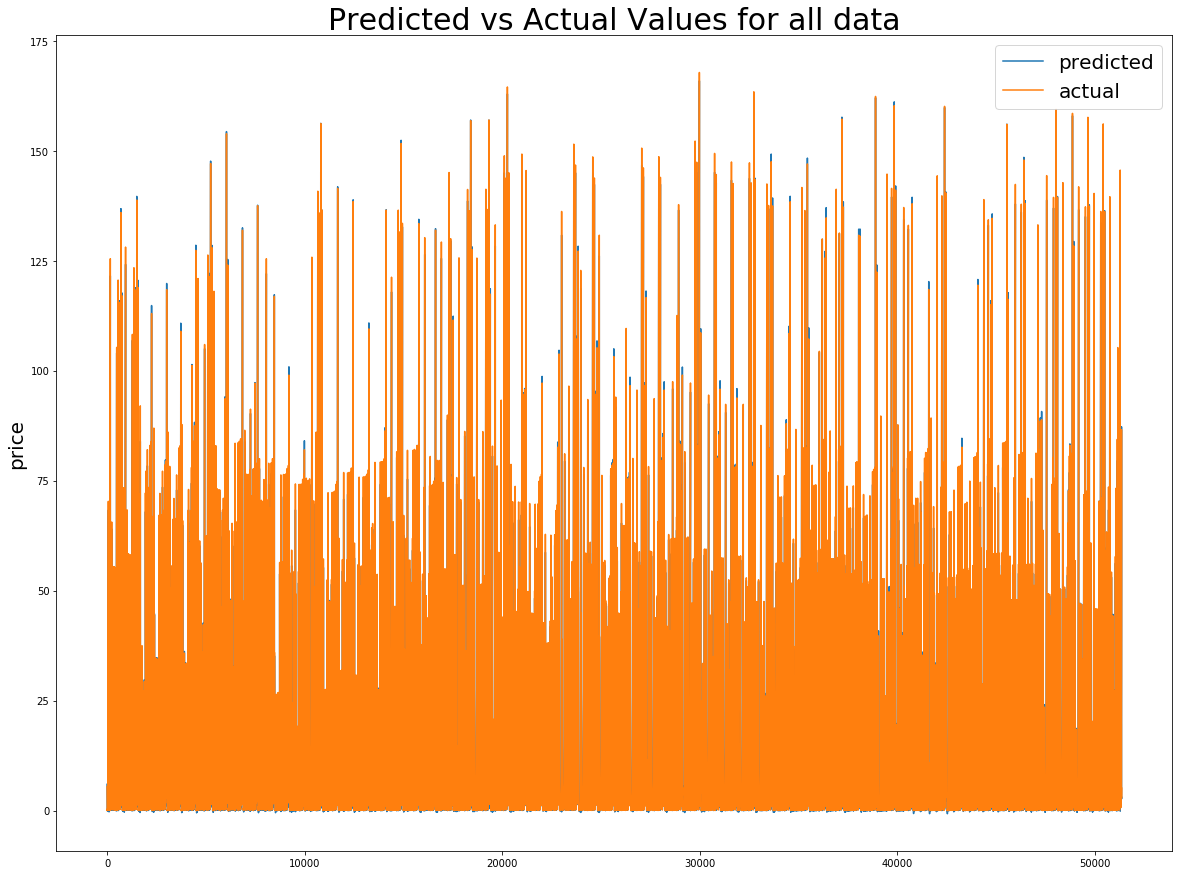

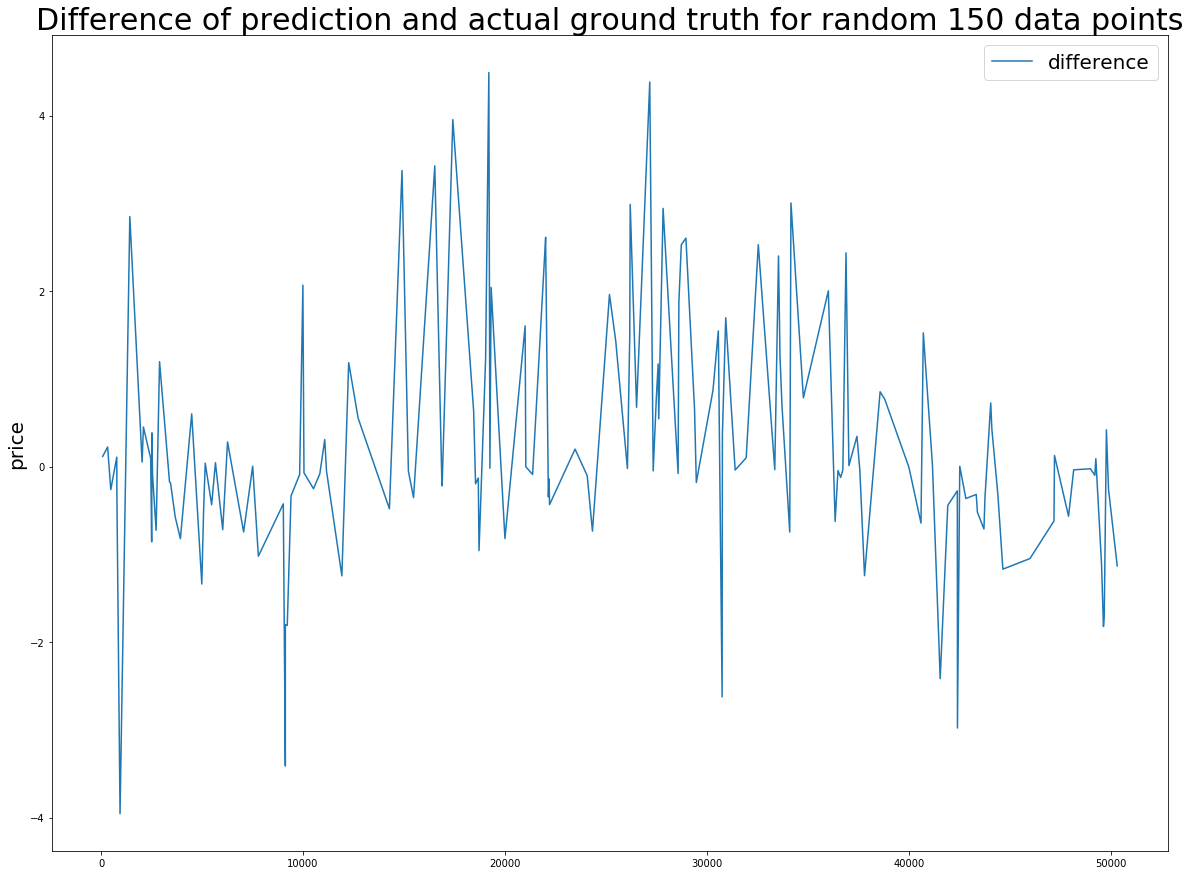

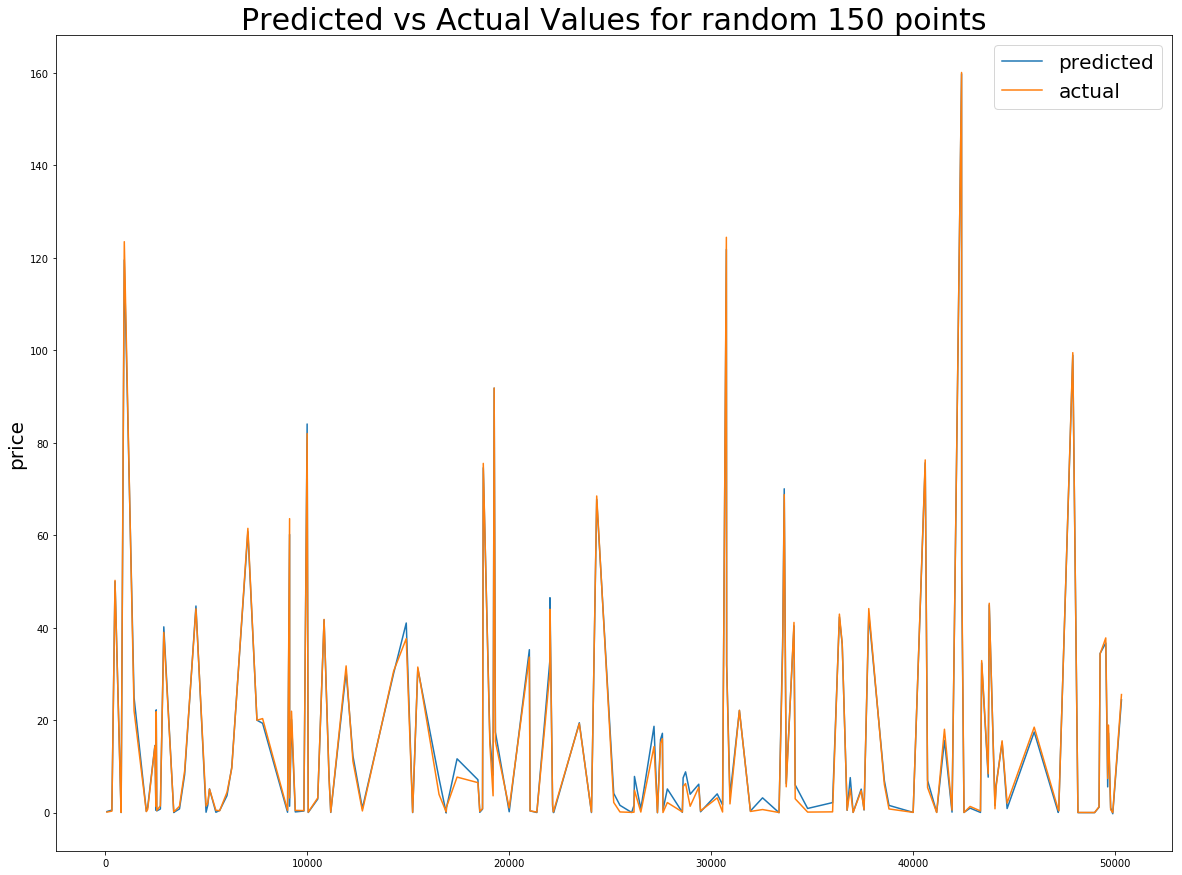

Mean absolute error (MAE):      0.868100
Mean squared error (MSE):       1.752869
Root mean squared error (RMSE): 1.323959
R square (R^2):                 0.997023


In [16]:
GS = df[df.ticker == 'GS']
model_pred_diff(GS, model, 'realized_vol')

y_predition:
 [[5.587867  ]
 [4.0667853 ]
 [2.586991  ]
 [1.6451551 ]
 [0.9201546 ]
 [0.55023926]
 [0.37298664]
 [0.28016374]
 [0.38902166]
 [0.15681261]]


actual value:
 [5.45 3.5  2.02 1.04 0.47 0.21 0.12 0.07 0.13 0.03]




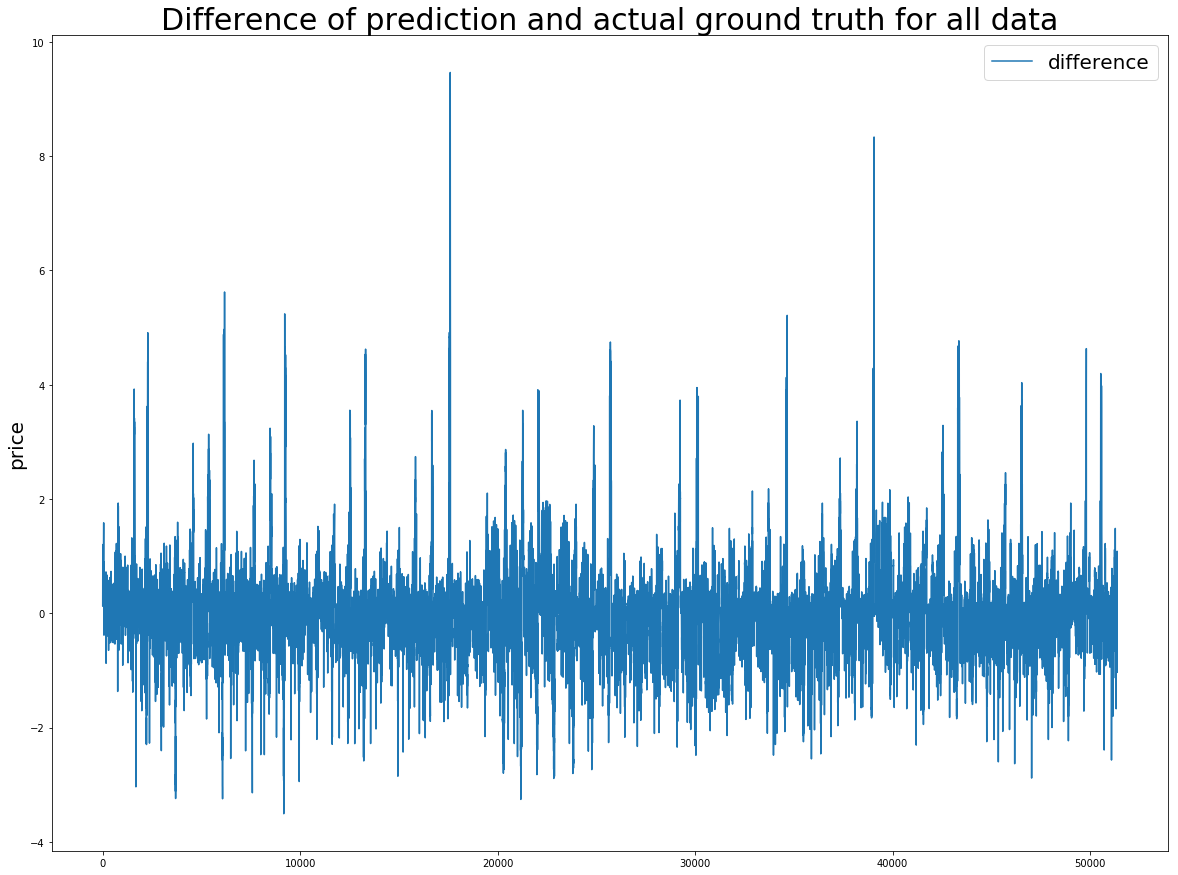

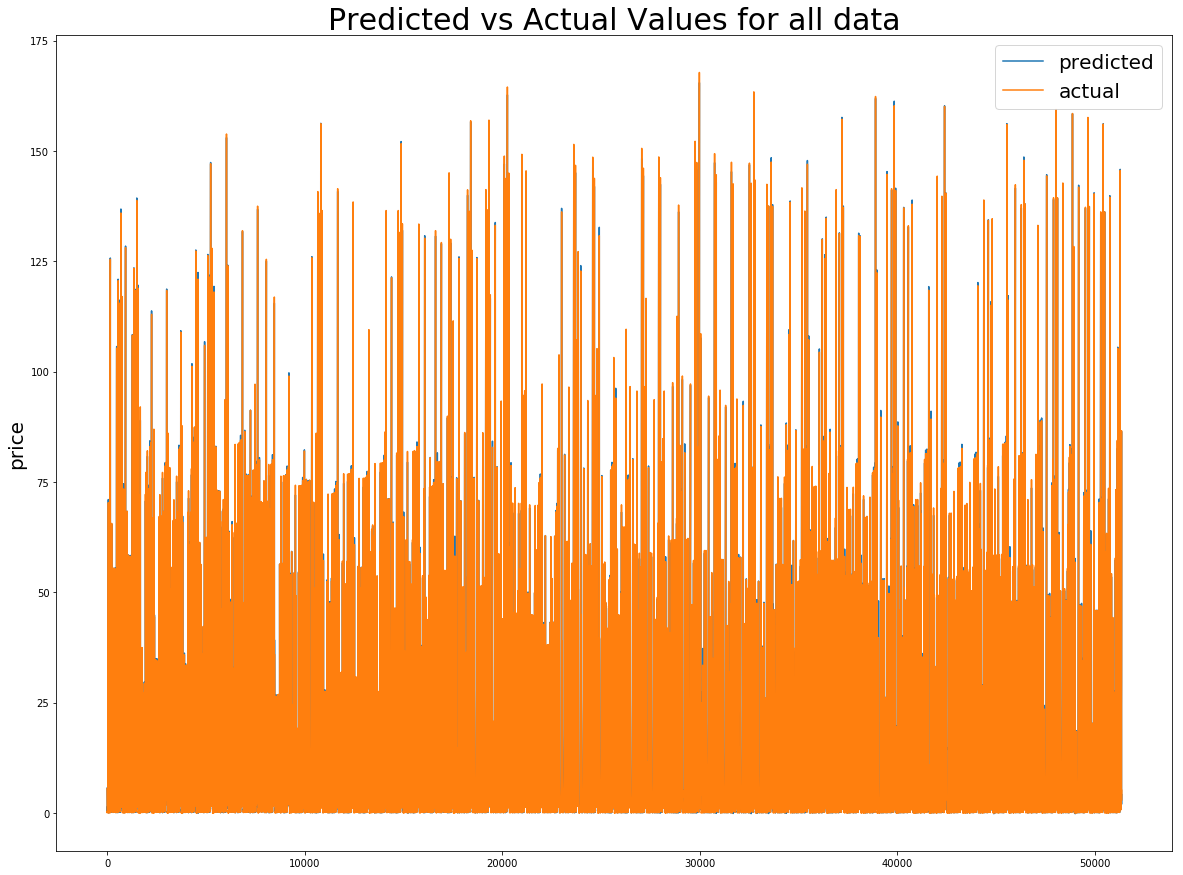

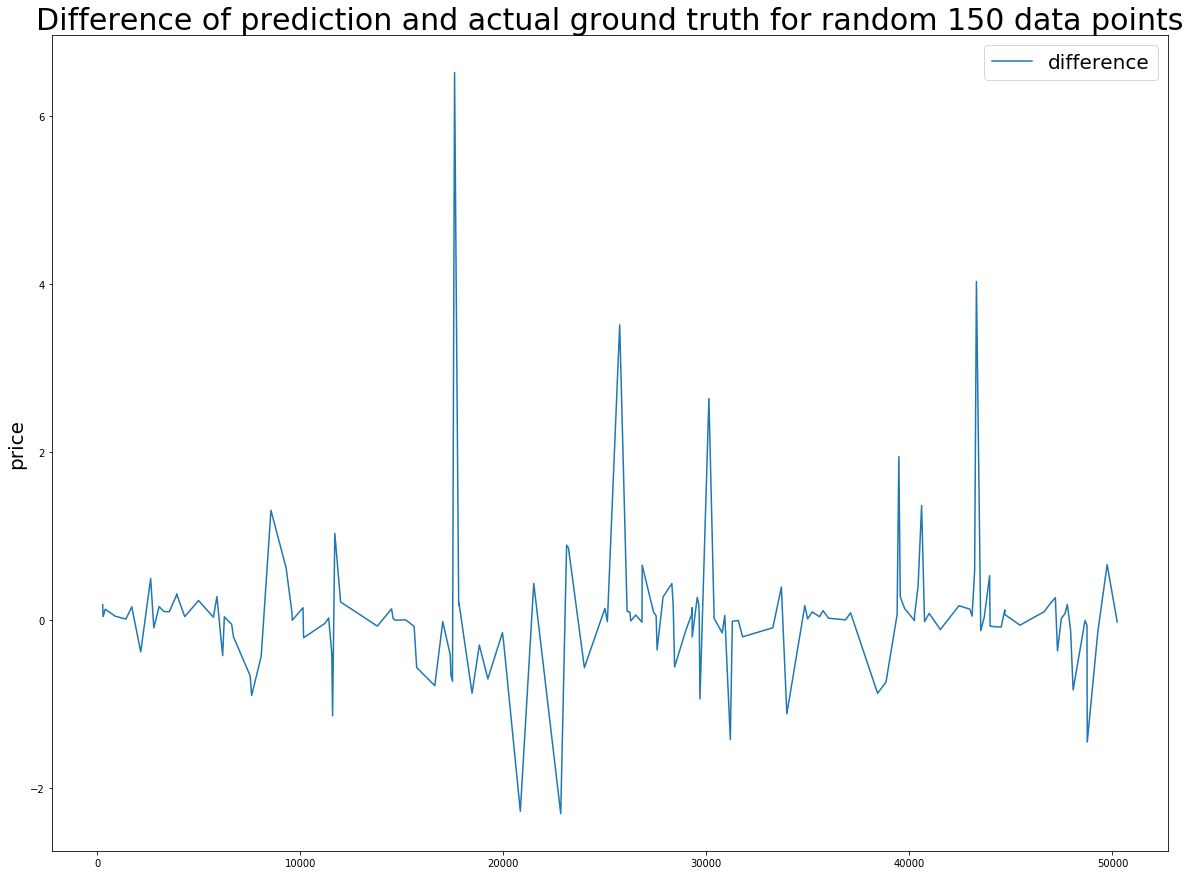

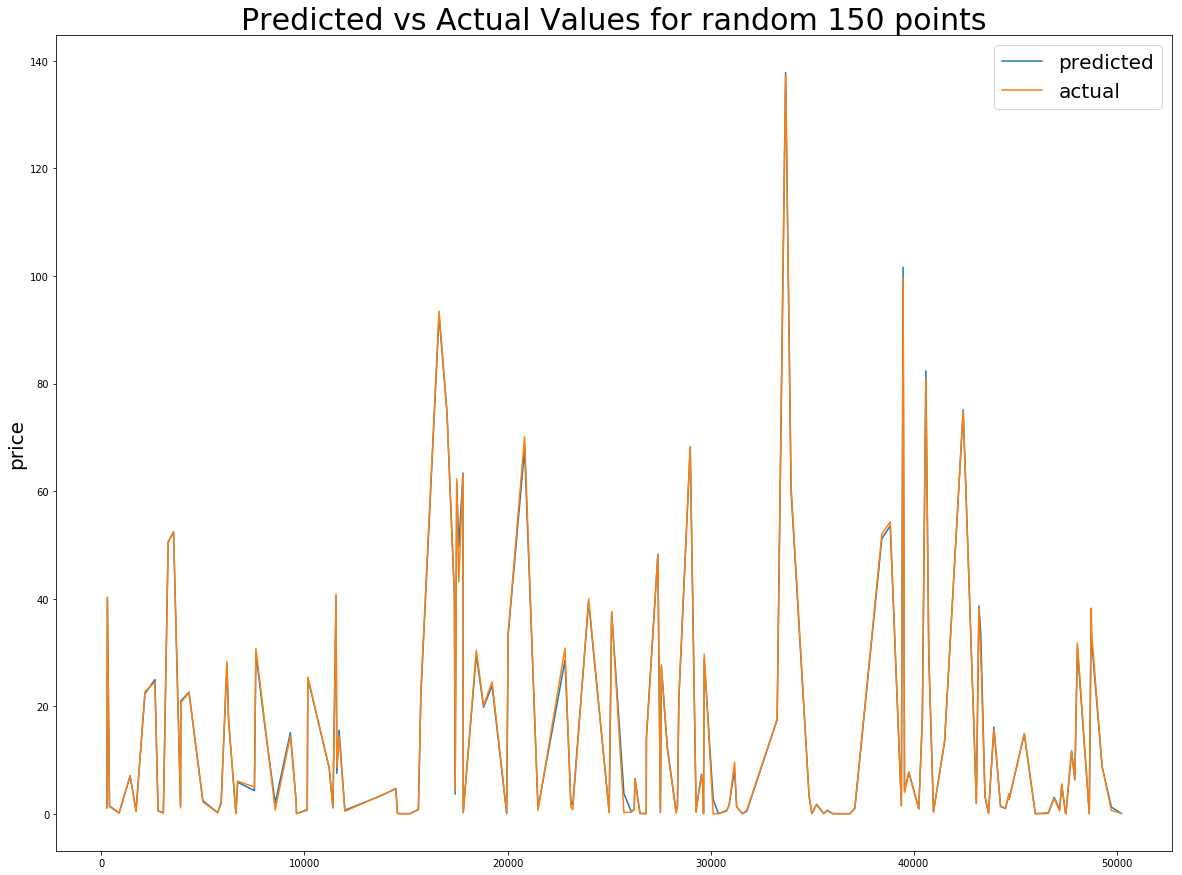

Mean absolute error (MAE):      0.401008
Mean squared error (MSE):       0.519540
Root mean squared error (RMSE): 0.720791
R square (R^2):                 0.999118


In [17]:
model_pred_diff(GS, model, 'impl_volatility')

y_predition:
 [[4.1376953 ]
 [3.1455524 ]
 [2.712378  ]
 [2.2336774 ]
 [1.8191768 ]
 [1.3983759 ]
 [0.9273198 ]
 [0.6376143 ]
 [0.4436586 ]
 [0.27851725]]


actual value:
 [4.55 3.55 2.88 2.27 1.84 1.46 1.09 0.79 0.54 0.34]




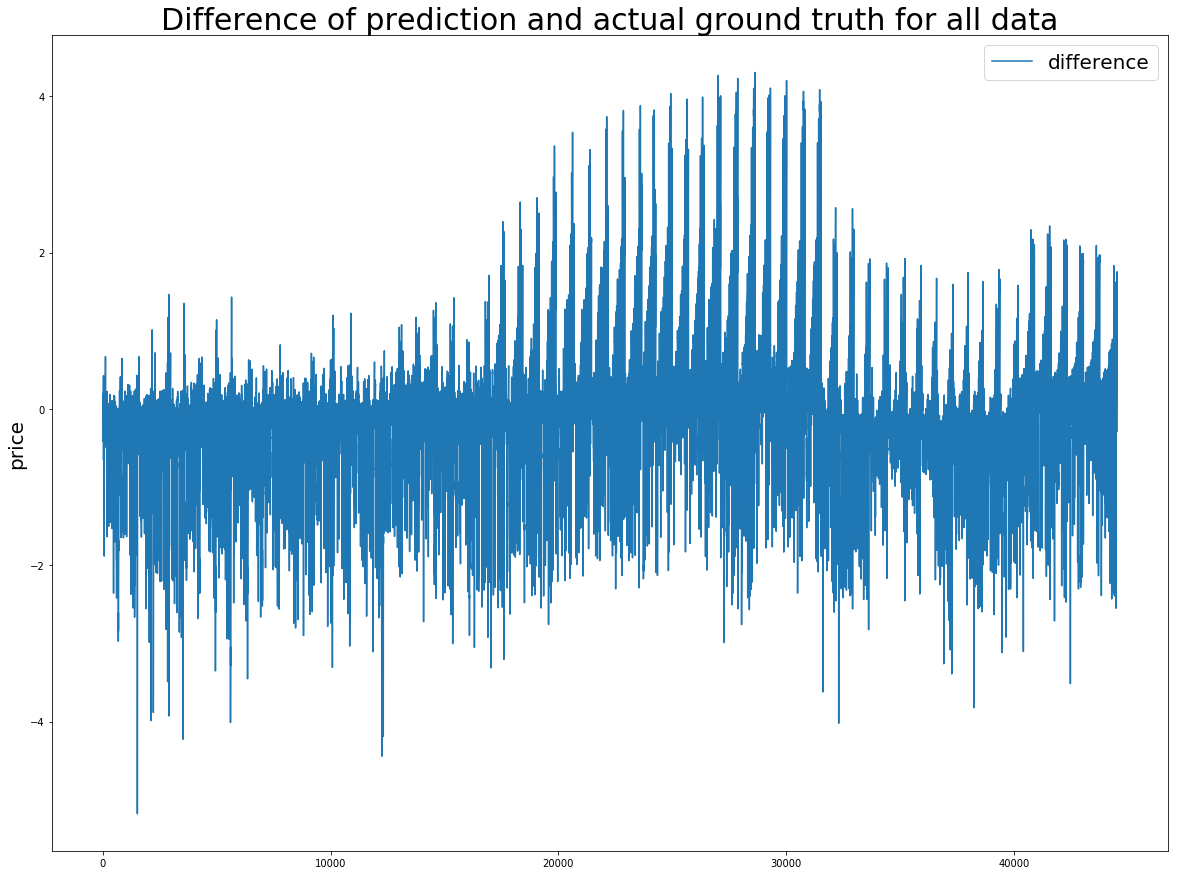

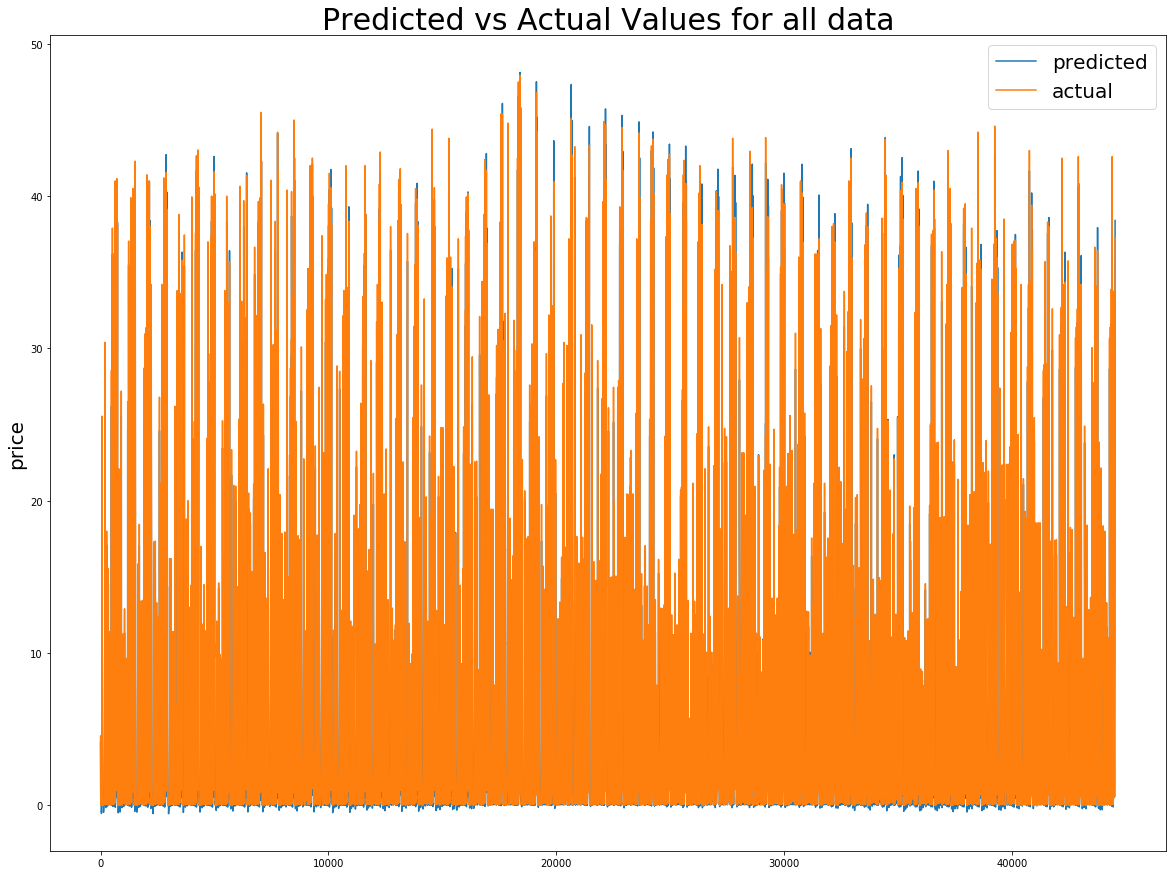

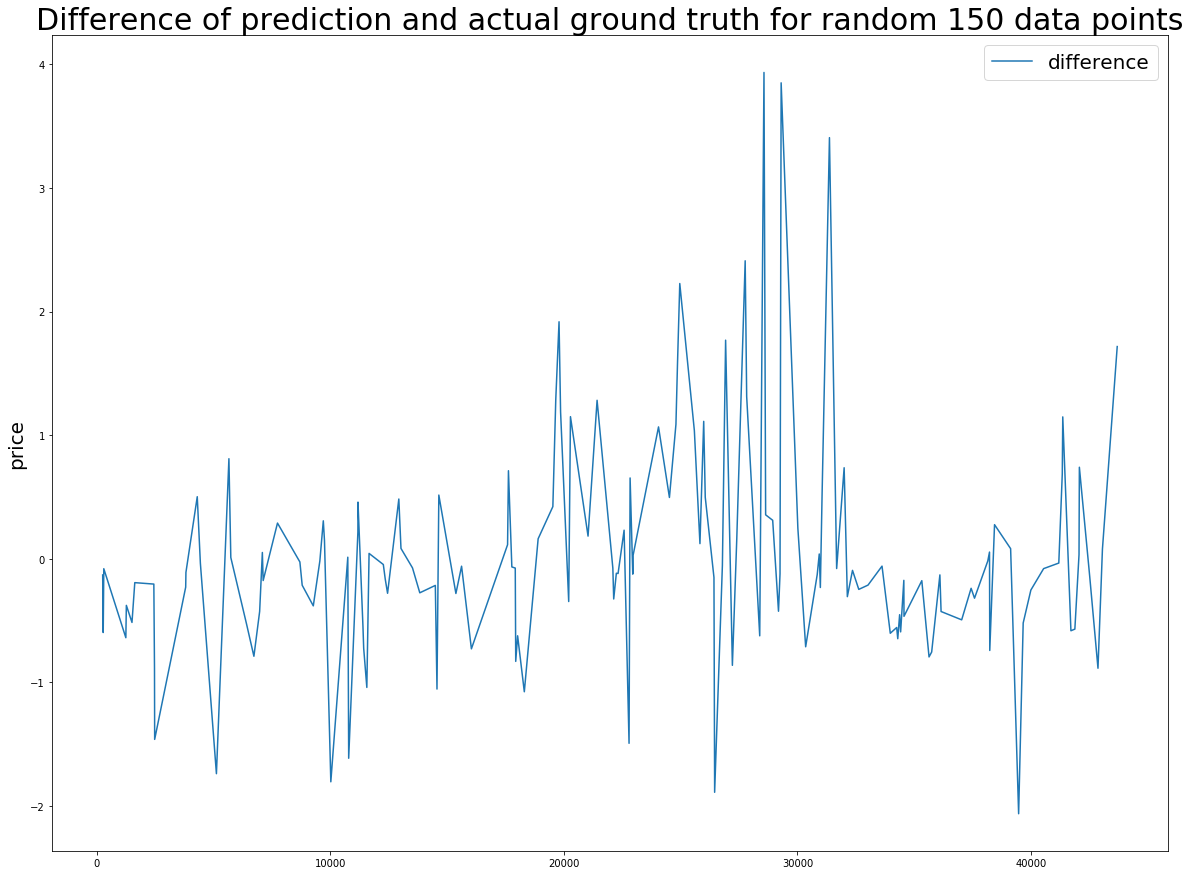

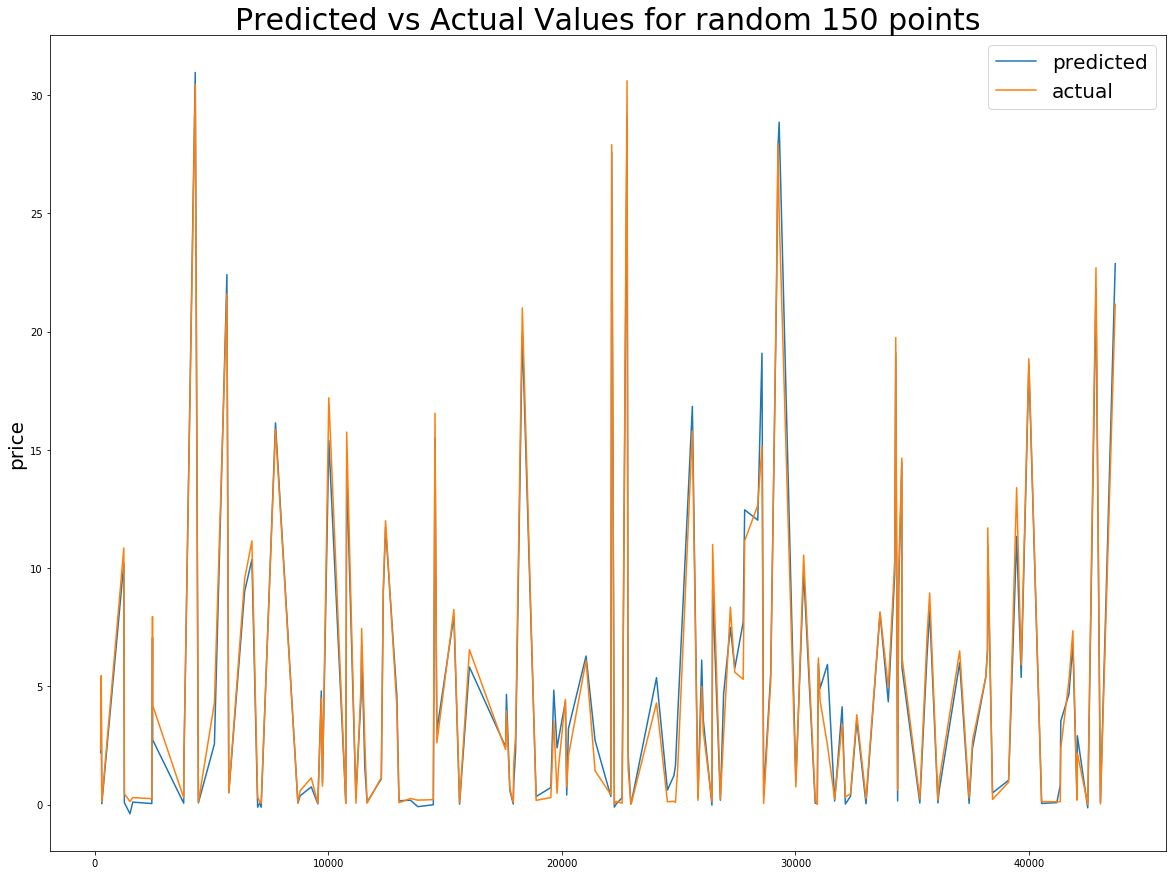

Mean absolute error (MAE):      0.555672
Mean squared error (MSE):       0.727885
Root mean squared error (RMSE): 0.853162
R square (R^2):                 0.987775


In [18]:
NKE = df[df.ticker == 'NKE']
model_pred_diff(NKE, model, 'realized_vol')

#### Predict special ticker which was not used to train the model

In [19]:
AAPL = pd.read_csv('Options2016AAPL_withReaVo.csv')
AAPL = AAPL.dropna()
AAPL.rename(columns = {'Strike Price':'strike_price', 'Lowest  Closing Ask Across All Exchanges':'best_offer', 
                       'Underlying Price':'underlying_price', 'C=Call, P=Put_C':'cp_flag_C', 'C=Call, P=Put_P':'cp_flag_P',
                       'volatility':'realized_vol'}, inplace = True);
AAPL.head()

,Unnamed: 0,strike_price,best_offer,underlying_price,maturity,cp_flag_C,cp_flag_P,interest_rate,days,realized_vol
0,0,100.0,5.45,105.35,4,1,0,0.0022,30,0.218791
1,1,101.0,4.50,105.35,4,1,0,0.0022,30,0.218791
2,2,102.0,3.65,105.35,4,1,0,0.0022,30,0.218791
3,3,103.0,2.79,105.35,4,1,0,0.0022,30,0.218791
4,4,104.0,2.06,105.35,4,1,0,0.0022,30,0.218791


In [20]:
AAPL['intrinsic'] = AAPL.apply(lambda row: intrinsic(row['underlying_price'], row['strike_price'], row['cp_flag_C'], 
                                                     row['cp_flag_P']), axis = 1)

y_predition:
 [[5.5018973 ]
 [4.5656805 ]
 [3.7116528 ]
 [2.8675425 ]
 [2.072785  ]
 [1.2959263 ]
 [0.8303964 ]
 [0.5089461 ]
 [0.2846397 ]
 [0.18298677]]


actual value:
 [5.45 4.5  3.65 2.79 2.06 1.43 0.93 0.56 0.32 0.18]




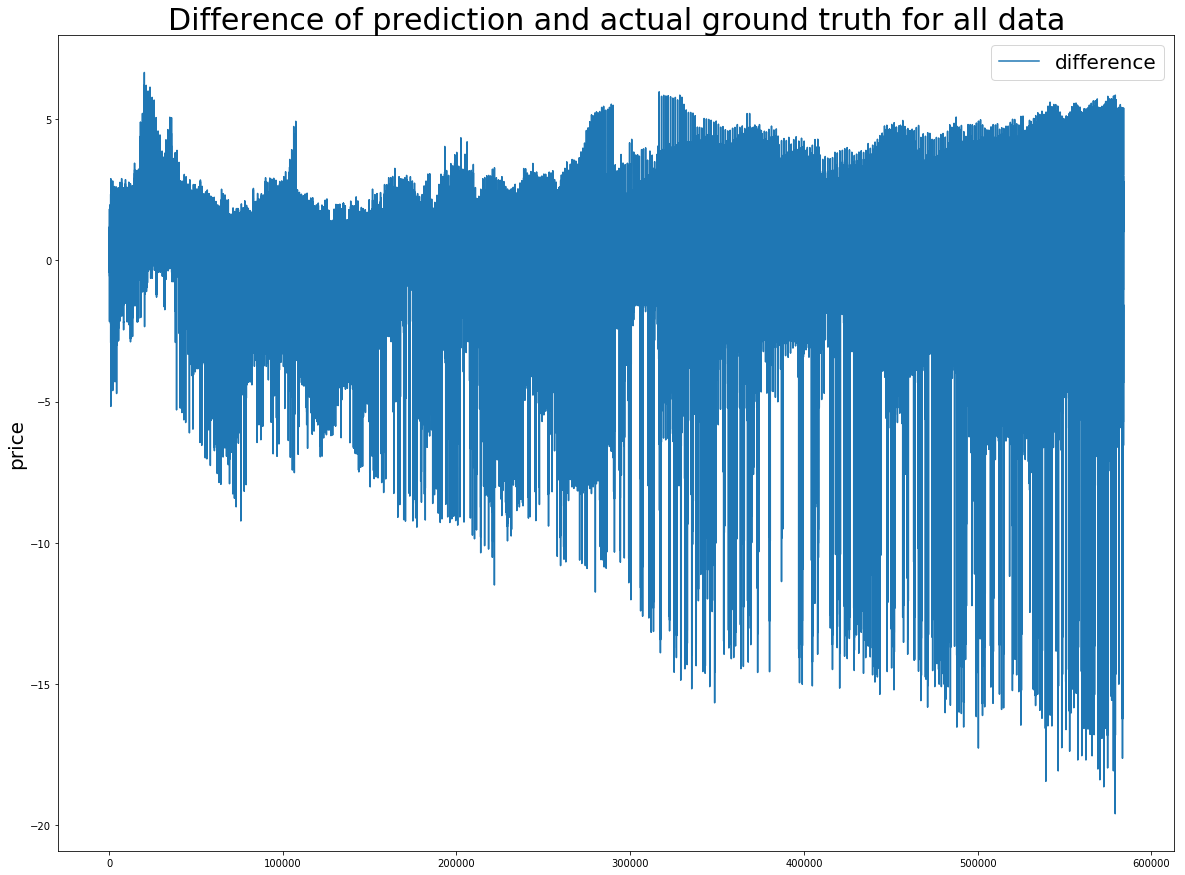

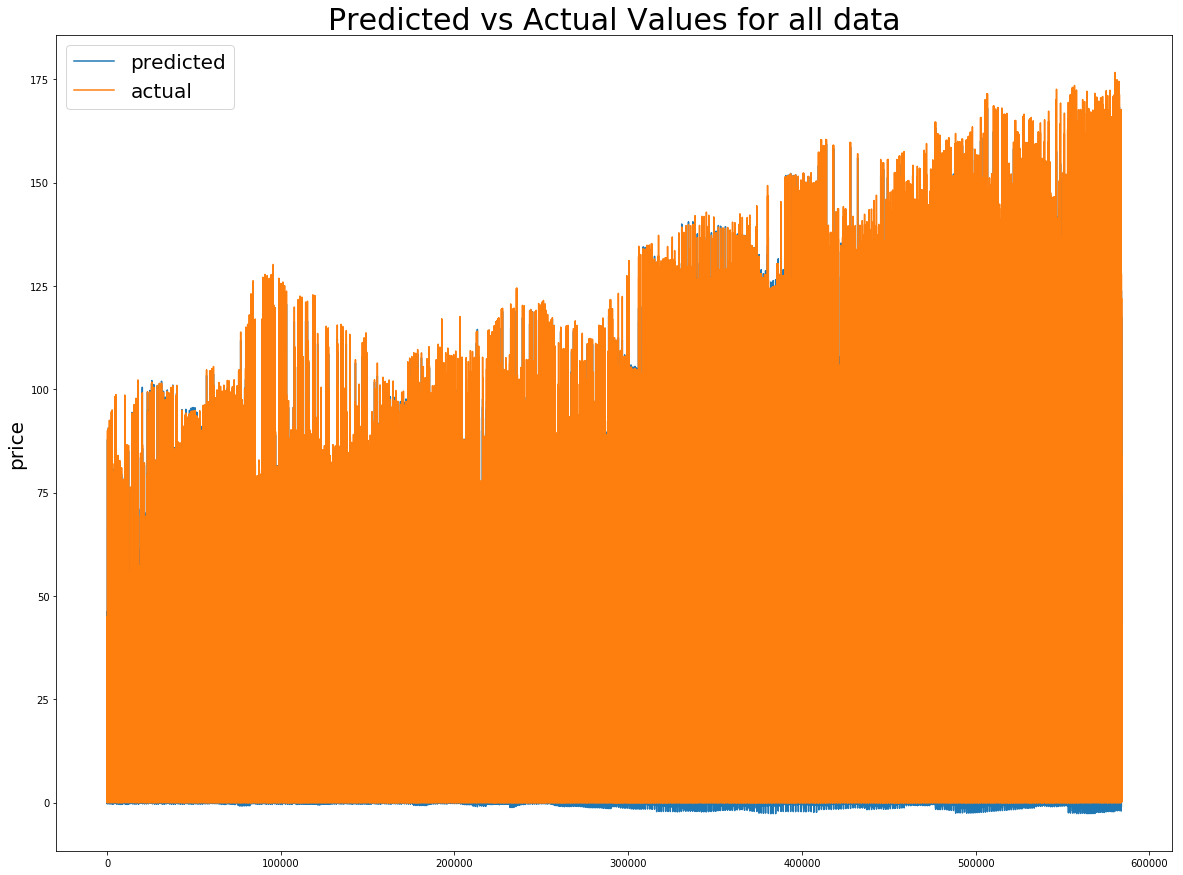

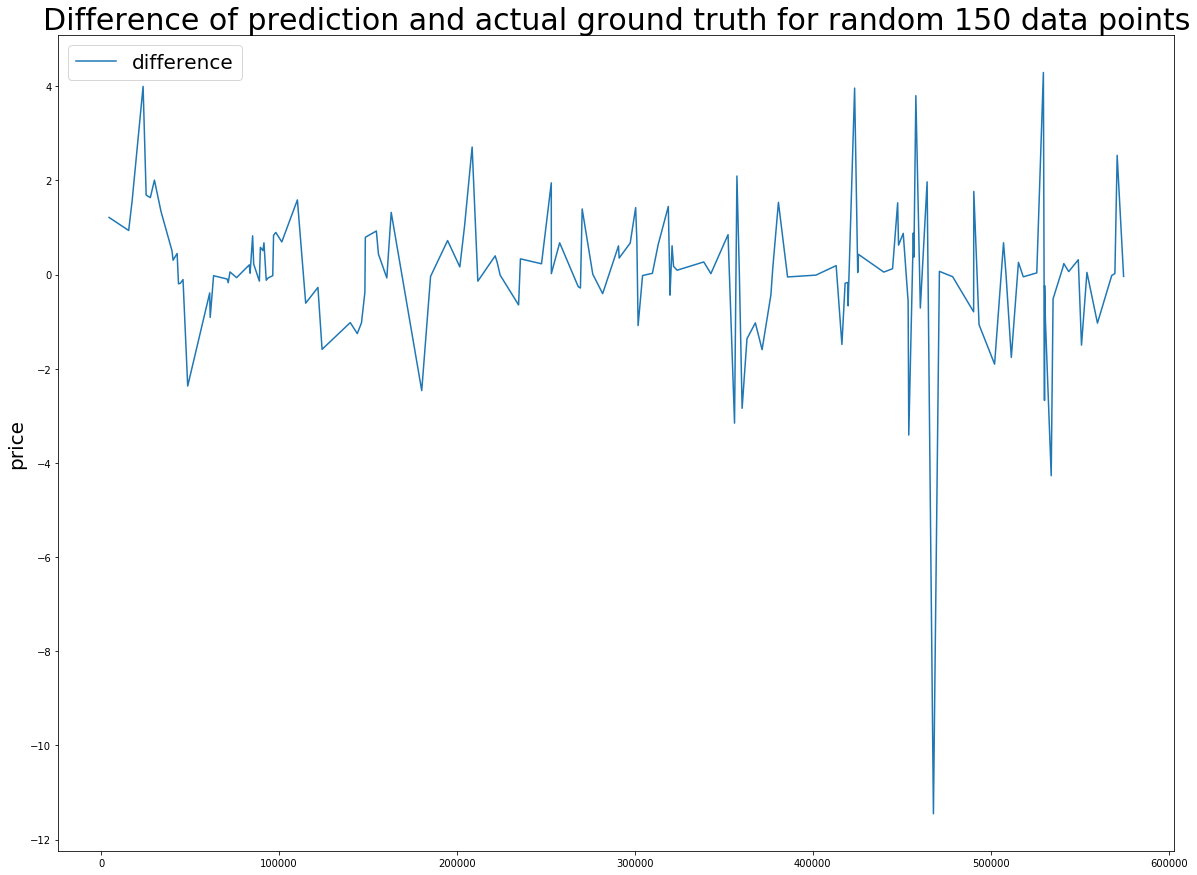

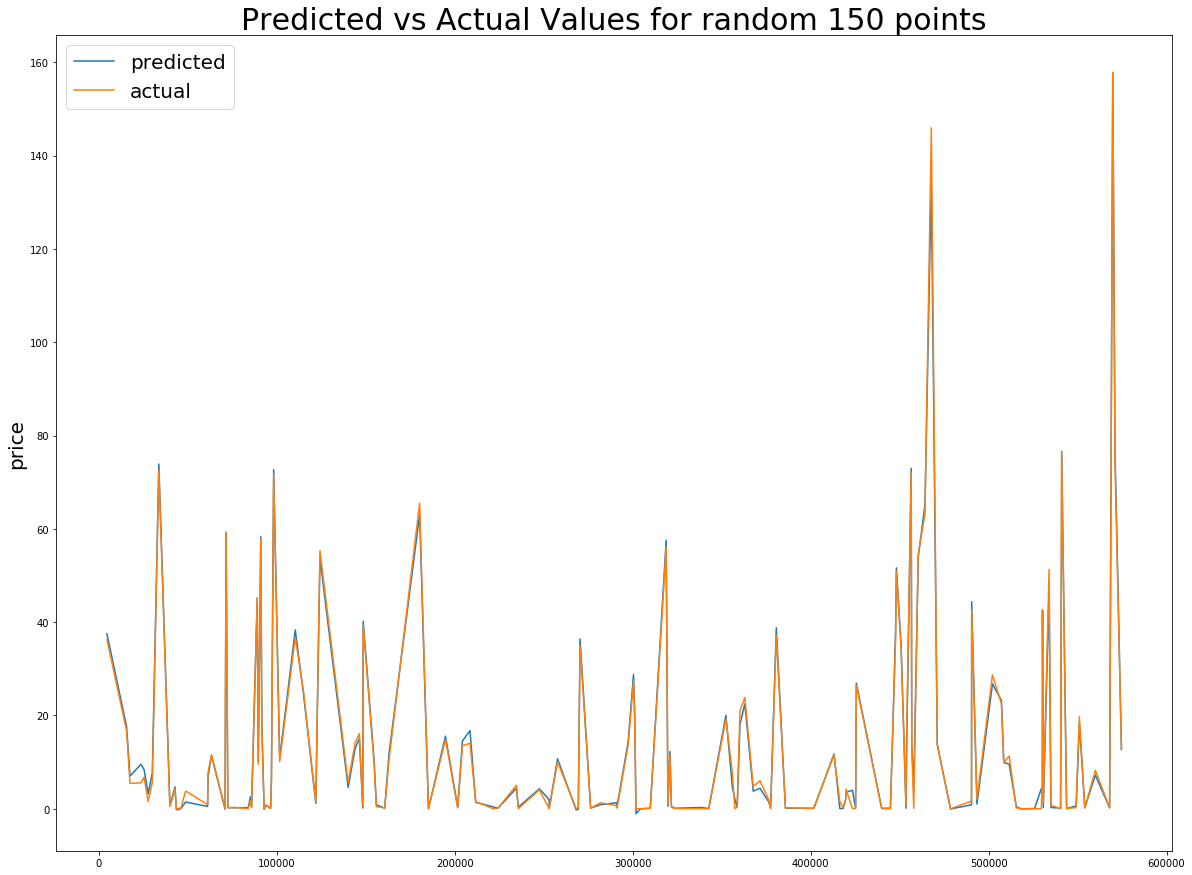

Mean absolute error (MAE):      0.912148
Mean squared error (MSE):       2.728452
Root mean squared error (RMSE): 1.651803
R square (R^2):                 0.995577


In [21]:
model_pred_diff(AAPL, model, 'realized_vol')